In [817]:
import pandas as pd
import os
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import requests
from collections import defaultdict
from matplotlib.ticker import MaxNLocator

In [1017]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [544]:
files = os.listdir('/project/manic-geo/irr/ihr')
ihr = sorted(['/project/manic-geo/irr/ihr/'+ i for i in files if i.startswith('origin_20')])
ihr_transit = sorted(['/project/manic-geo/irr/ihr/'+ i for i in files if i.startswith('transit')])

# MANRS Networks

In [4]:
manrs = []
manrs_org = {}
manrs_org2as = defaultdict(list)
with open('manrs_isps.csv', 'rt') as f:
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[2].split(';')
        for i in asns:
            try:
                manrs.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

In [5]:
manrscdn = []
with open('manrs_cdns.csv', 'rt') as f:
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[1].split(';')
        for i in asns:
            if not i.isdigit():
                continue
            try:
                manrscdn.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

In [6]:
manrscdn

[20940,
 52580,
 59414,
 266444,
 50520,
 135337,
 54825,
 8280,
 14061,
 32934,
 8075,
 8074,
 2906,
 40027,
 55095,
 13335,
 16509,
 133800,
 15169,
 7342,
 20473]

In [7]:
manrsas = manrs + manrscdn

In [889]:
len(manrs)

849

In [890]:
len(manrscdn)

21

In [213]:
oldmanrsdf = pd.read_csv('MANRS Participants.csv')
oldmanrs = []
for i,v in oldmanrsdf.iterrows():
    for j in v['ASNs'].strip().split(','):
        if len(j) == 0:
            continue
        oldmanrs.append(int(j))

## Group by size (number of customers)  
#customers < 2: small; \[2, 180\] : medium; > 180: large

In [8]:
cust_deg = pd.read_csv('/data/external/as-rank-ribs/20220301/asclass/as-rel-data/20220301.cpr.txt', delimiter='|', names=['asn', 'what', 'cust', 'provider', 'peer'])
small = cust_deg[cust_deg.cust <= 2]['asn']
medium = cust_deg[(cust_deg.cust > 2) & (cust_deg.cust < 180)]['asn']
large = cust_deg[cust_deg.cust >= 180]['asn']

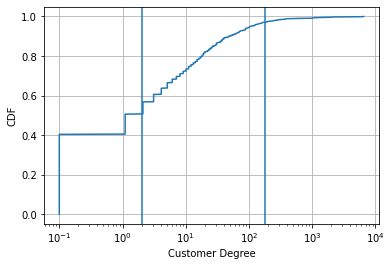

In [697]:
plt.plot(np.sort(cust_deg[cust_deg.asn.isin(manrsas)]['cust']+0.1), np.linspace(0,1,len(cust_deg[cust_deg.asn.isin(manrsas)])))
plt.xscale('log')
plt.xlabel('Customer Degree')
plt.ylabel('CDF')
plt.grid()
plt.axvline(2)
plt.axvline(180)

In [9]:
ec = cust_deg[(cust_deg.cust < 2) & (cust_deg.peer <= 1)]['asn']
stp = cust_deg[((cust_deg.cust >= 2) & (cust_deg.cust < 180) & (cust_deg.peer < 4))|((cust_deg.cust >= 48) & (cust_deg.cust < 180) & (cust_deg.peer >= 4)) ]['asn']
cahp = cust_deg[(cust_deg.cust < 2) & (cust_deg.peer > 1) | ((cust_deg.cust >= 2)& (cust_deg.cust < 48) & (cust_deg.peer >= 4))]['asn']
ltp = cust_deg[cust_deg.cust >= 180]['asn']

In [10]:
print(len(small), len(medium), len(large))

68834 4808 110


In [11]:
print(len(ec), len(stp), len(cahp), len(ltp))

60360 3564 9718 110


In [12]:
cust_deg[cust_deg.asn == 16509]['cust'] < 2

820    False
Name: cust, dtype: bool

In [13]:
for i in manrscdn:
    print(i, i in cahp.values)

20940 True
52580 True
59414 True
266444 True
50520 True
135337 False
54825 True
8280 True
14061 True
32934 True
8075 True
8074 False
2906 True
40027 False
55095 False
13335 False
16509 True
133800 False
15169 True
7342 False
20473 False


In [14]:
7342 in stp.values

True

In [15]:
16509 in ec

True

In [16]:
small_manrs = set(manrsas).intersection(set(small))
medium_manrs = set(manrsas).intersection(set(medium))
large_manrs = set(manrsas).intersection(set(large))

In [17]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

451 319 24


In [18]:
449+315+24

788

<span style='color:red'>ASes without customer info (0 customers) but belongs to large network e.g. AS7756, charter</span>

In [19]:
small_non_manrs = set(small) - small_manrs
medium_non_manrs = set(medium) - medium_manrs
large_non_manrs = set(large) - large_manrs

# Originating Prefixes

In [395]:
origindf = pd.read_csv('/project/manic-geo/irr/ihr/origin_v4_2022-05-01.csv.gz', index_col=0)
origindf = origindf[origindf.af == 4]

In [332]:
ihr[-1]

'/project/manic-geo/irr/ihr/origin_2022-05-01.csv.gz'

In [396]:
origindf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
691982,1415697055,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691984,1415697053,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691986,1415697051,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691988,1415697049,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691990,1415697047,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294722,1411094442,2022-05-01 00:00:00+00,1.6.73.0/24,1.000000,4,99.453552,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
5294723,1411094441,2022-05-01 00:00:00+00,1.32.0.0/19,1.000000,4,98.907104,Valid,Valid,assigned,assigned,Telekom Malaysia Berhad\nCore IP & NGN\n17th F...,f,4788,MY,4788
5294724,1411094440,2022-05-01 00:00:00+00,1.72.0.0/23,1.000000,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,9605,JP,9605
5294725,1411094439,2022-05-01 00:00:00+00,1.66.90.0/24,1.000000,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,9605,JP,9605


In [397]:
manrs_origin = origindf[origindf.originasn_id.isin(manrsas)]
non_manrs_origin = origindf[~origindf.originasn_id.isin(manrsas)]

In [398]:
manrs_origin['nettype'] = manrs_origin['originasn_id'].apply(lambda x: 'CDN' if x in manrscdn else 'ISP')

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [399]:
small_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(small)]
medium_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(medium)]
large_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(large)]

In [400]:
small_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(small)]
medium_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(medium)]
large_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(large)]

## RPKI

### Does MANRS networks originate more prefixes with RPKI record?

In [401]:
manrs_origin_rpki = manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
manrs_origin_rpki['rpki_percent'] = (1-manrs_origin_rpki['NotFound']/manrs_origin_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [402]:
manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent
0,87,0,0,4,13,76.470588
1,88,0,0,4,6,60.000000
2,92,0,0,0,4,100.000000
3,101,0,0,0,4,100.000000
4,103,0,0,22,0,0.000000
...,...,...,...,...,...,...
764,395262,0,0,0,1,100.000000
765,396955,0,0,1,9,90.000000
766,396961,0,0,0,5,100.000000
767,398866,0,0,2,0,0.000000


In [403]:
non_manrs_origin_rpki = non_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
non_manrs_origin_rpki['rpki_percent'] = (1-non_manrs_origin_rpki['NotFound']/non_manrs_origin_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [404]:
non_manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent
0,1,0,0,5,0,0.000000
1,2,3,0,11,0,21.428571
2,3,8,0,144,0,5.263158
3,4,1,0,47,0,2.083333
4,5,0,0,7,2,22.222222
...,...,...,...,...,...,...
72144,401308,0,0,0,1,100.000000
72145,1440665,0,0,1,0,0.000000
72146,424058000,0,0,1,0,0.000000
72147,4200006001,0,0,1,0,0.000000


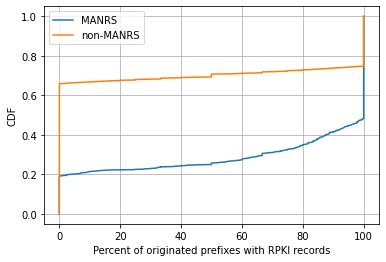

In [405]:
plt.plot(np.sort(manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(manrs_origin_rpki)), label='MANRS')
plt.plot(np.sort(non_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(non_manrs_origin_rpki)), label='non-MANRS')
plt.xlabel('Percent of originated prefixes with RPKI records')
plt.ylabel('CDF')
plt.legend()
plt.grid()


MANRS networks are more likely to originate prefixes registered in RPKI

In [406]:
small_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(small)]
medium_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(medium)]
large_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(large)]

In [407]:
small_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(small)]
medium_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(medium)]
large_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(large)]

In [408]:
# small_manrs_origin_rpki = small_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# small_manrs_origin_rpki['rpki_percent'] = (1-small_manrs_origin_rpki['NotFound']/small_manrs_origin_rpki.sum(axis=1))*100

# medium_manrs_origin_rpki = medium_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# medium_manrs_origin_rpki['rpki_percent'] = (1-medium_manrs_origin_rpki['NotFound']/medium_manrs_origin_rpki.sum(axis=1))*100

# large_manrs_origin_rpki = large_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# large_manrs_origin_rpki['rpki_percent'] = (1-large_manrs_origin_rpki['NotFound']/large_manrs_origin_rpki.sum(axis=1))*100

In [409]:
# small_non_manrs_origin_rpki = small_non_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# small_non_manrs_origin_rpki['rpki_percent'] = (1-small_non_manrs_origin_rpki['NotFound']/small_non_manrs_origin_rpki.sum(axis=1))*100

# medium_non_manrs_origin_rpki = medium_non_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# medium_non_manrs_origin_rpki['rpki_percent'] = (1-medium_non_manrs_origin_rpki['NotFound']/medium_non_manrs_origin_rpki.sum(axis=1))*100

# large_non_manrs_origin_rpki = large_non_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0)
# large_non_manrs_origin_rpki['rpki_percent'] = (1-large_non_manrs_origin_rpki['NotFound']/large_non_manrs_origin_rpki.sum(axis=1))*100

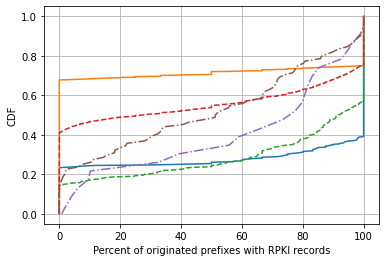

In [410]:
#plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(small_manrs_origin_rpki)), label='small MANRS', linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(small_non_manrs_origin_rpki)), label='small non-MANRS', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(medium_manrs_origin_rpki)), label='medium MANRS', linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(medium_non_manrs_origin_rpki)), label='medium non-MANRS', linestyle='--')
plt.plot(np.sort(large_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(large_manrs_origin_rpki)), label='large MANRS', linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_rpki['rpki_percent']), np.linspace(0,1,len(large_non_manrs_origin_rpki)), label='large non-MANRS', linestyle='-.')
plt.xlabel('Percent of originated prefixes with RPKI records')
plt.ylabel('CDF')
#plt.xlim(80,105)
#plt.legend()
plt.grid()

not all ASes of a network has to register in RPKI  
still have small ASes register RPKI, beyond manrs  
common ownership of those ASes  
siblings of registered manrs ASes  

### Sibling ASes of MANRS networks

In [411]:
path = '20220401.as-org2info.txt'
mapping = {}
companyname = {}
org2as = defaultdict(list)

with open(path, 'rt') as as2org:
    for line in as2org:
        l = line.strip('\n').split('|')
        asn = None
        if l[0].isdigit():
            asn = l[0]
            mapping[int(asn)] = l[3]
        elif len(l) == 5:
            companyname[l[0]] = (l[2], l[3])
    for i in mapping:
        orgname = companyname[mapping[i]]
        mapping[i] = orgname
        org2as[orgname].append(i)

manually merge china telecom

In [412]:
manrs_org2as.pop('China Telecom Global Limited', None)

In [413]:
manrs_org2as['China Telecom']

[4809, 4134]

In [414]:
manrs_org2as

defaultdict(list,
            {'GIBIRNET': [208972],
             'Windstream Communication Limited': [139009],
             'Sndc communication Pvt Ltd': [142419],
             'SUPER CONNECT TELECOM LTDA': [262300],
             'Valor Christian High School': [36289],
             'Farzanegan Pars': [200370],
             'BT Ireland': [2110],
             'CEDIA': [61468, 27841, 27820, 262212],
             'TOHUNET': [140731],
             'Cyber Internet Telecom': [262565],
             'CD ONE Corporation do Brasil': [52818],
             'TDC': [3292],
             '76 Telecom Telecomunicações Ltda': [262760, 262363],
             'Implex.net': [21709],
             'TECMAIS TELECOMUNICAÇÕES': [61785],
             'CLICK CONNECT': [267113],
             'Radar Internet': [262880],
             'URAN Association': [12687],
             'nts workspace ag': [15576, 39040],
             'MobiCom Corporation': [55805, 9484],
             'State of South Dakota - BIT': [7773, 14263, 

In [415]:
sibling_not_in_manrs = defaultdict(list)
for i in manrs_org2as:
    registered_AS = manrs_org2as[i]
    marker = False
    for rep_AS in registered_AS:
        if marker == True:
            break
        if rep_AS in mapping:
            siblings = org2as[mapping[rep_AS]]
            for j in siblings:
                if j not in registered_AS:
                    sibling_not_in_manrs[i].append(j)
            marker = True

In [416]:
org2as[mapping[20940]]

[20940,
 21342,
 21357,
 21399,
 31107,
 31108,
 31109,
 31110,
 31377,
 33905,
 34164,
 34850,
 35204,
 39836,
 43639,
 48163,
 49249,
 49846,
 200005,
 213120]

In [417]:
len(sibling_not_in_manrs)

204

In [418]:
sibling_not_in_manrs

defaultdict(list,
            {'GIBIRNET': [59510],
             'Windstream Communication Limited': [59203],
             'Sndc communication Pvt Ltd': [38230,
              134828,
              136918,
              137490,
              137509,
              137520,
              139308,
              141702,
              141703,
              142039,
              142289,
              142597,
              142598,
              142632,
              142635,
              149434,
              149435],
             'BT Ireland': [3286, 24622],
             'TOHUNET': [132623,
              133555,
              134477,
              134488,
              134708,
              134993,
              136591,
              137835,
              139231,
              139317,
              139734,
              140506,
              140961,
              141429,
              141445,
              141694,
              141776,
              142111,
              142112,
              1

In [419]:
sibling_actually_not_in_manrs = defaultdict(list)
for i in sibling_not_in_manrs:
    for AS in sibling_not_in_manrs[i]:
        if AS not in manrs:
            sibling_actually_not_in_manrs[i].append(AS)

In [420]:
len(sibling_actually_not_in_manrs)

199

In [421]:
sibling_actually_not_in_manrs['Comcast']

[6161,
 7757,
 7853,
 13385,
 14668,
 16748,
 23253,
 23266,
 33351,
 33542,
 33658,
 33663,
 36196,
 36377,
 53297,
 393232,
 395974,
 395976,
 395980,
 396017,
 396019,
 396021,
 396415]

In [422]:
sibling_dist = {}
for i in sibling_actually_not_in_manrs:
    sibling_dist[i] = len(sibling_actually_not_in_manrs[i])

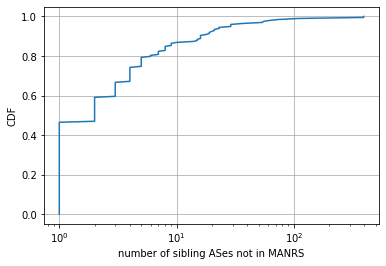

In [423]:
plt.plot(np.sort(list(sibling_dist.values())), np.linspace(0,1,len(sibling_dist)))
plt.xscale('log')
plt.xlabel('number of sibling ASes not in MANRS')
plt.ylabel('CDF')
plt.grid()

In [533]:
sibling_actually_not_in_manrs['Comcast']

[6161,
 7757,
 7853,
 13385,
 14668,
 16748,
 23253,
 23266,
 33351,
 33542,
 33658,
 33663,
 36196,
 36377,
 53297,
 393232,
 395974,
 395976,
 395980,
 396017,
 396019,
 396021,
 396415]

In [425]:
as_non_manrs_sibling = set()
for i in sibling_actually_not_in_manrs:
    for j in sibling_actually_not_in_manrs[i]:
        as_non_manrs_sibling.add(j)

distribution

In [426]:
len(as_non_manrs_sibling)

1489

In [427]:
all(i not in manrs for i in as_non_manrs_sibling)

True

### Does MANRS originate more RPKI valids than non_MANRS?

In [538]:
manrs_origin_rpki['valid_percent'] = (manrs_origin_rpki['Valid']/manrs_origin_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100
non_manrs_origin_rpki['valid_percent'] = (non_manrs_origin_rpki['Valid']/non_manrs_origin_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100
sibling_non_manrs_origin_rpki['valid_percent'] = (sibling_non_manrs_origin_rpki['Valid']/sibling_non_manrs_origin_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100



/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


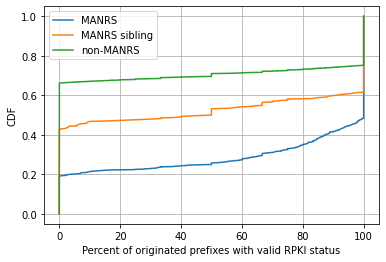

In [540]:
plt.plot(np.sort(manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(manrs_origin_rpki['valid_percent'])), label='MANRS')
plt.plot(np.sort(sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(sibling_non_manrs_origin_rpki['valid_percent'])), label='MANRS sibling')
plt.plot(np.sort(non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(non_manrs_origin_rpki['valid_percent'])), label='non-MANRS')
plt.xlabel('Percent of originated prefixes with valid RPKI status')
plt.ylabel('CDF')
plt.legend()
plt.grid()

In [430]:
small_manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent
0,87,0,0,4,13,76.470588
1,88,0,0,4,6,60.000000
2,92,0,0,0,4,100.000000
4,103,0,0,22,0,0.000000
5,111,0,0,20,0,0.000000
...,...,...,...,...,...,...
764,395262,0,0,0,1,100.000000
765,396955,0,0,1,9,90.000000
766,396961,0,0,0,5,100.000000
767,398866,0,0,2,0,0.000000


In [716]:
len(small_manrs - set(small_manrs_origin_rpki['originasn_id']))

18

In [715]:
origindf[origindf.originasn_id == 4323]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id


In [431]:
small_manrs_origin_rpki['valid_percent'] = (small_manrs_origin_rpki['Valid']/small_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
small_non_manrs_origin_rpki['valid_percent'] = (small_non_manrs_origin_rpki['Valid']/small_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
small_sibling_non_manrs_origin_rpki['valid_percent'] = (small_sibling_non_manrs_origin_rpki['Valid']/small_sibling_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

medium_manrs_origin_rpki['valid_percent'] = (medium_manrs_origin_rpki['Valid']/medium_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
medium_non_manrs_origin_rpki['valid_percent'] = (medium_non_manrs_origin_rpki['Valid']/medium_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
medium_sibling_non_manrs_origin_rpki['valid_percent'] = (medium_sibling_non_manrs_origin_rpki['Valid']/medium_sibling_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

large_manrs_origin_rpki['valid_percent'] = (large_manrs_origin_rpki['Valid']/large_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
large_non_manrs_origin_rpki['valid_percent'] = (large_non_manrs_origin_rpki['Valid']/large_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
large_sibling_non_manrs_origin_rpki['valid_percent'] = (large_sibling_non_manrs_origin_rpki['Valid']/large_sibling_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


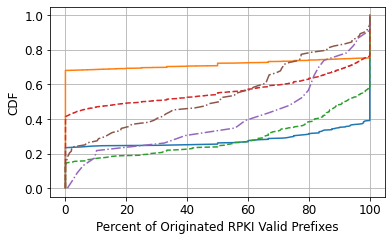

In [1018]:
plt.figure(figsize=(6,3.5))
plt.plot(np.sort(small_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_manrs_origin_rpki)), label='small MANRS', linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_rpki)), label='small non-MANRS', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_rpki)), label='medium MANRS', linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_rpki)), label='medium non-MANRS', linestyle='--')
plt.plot(np.sort(large_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_manrs_origin_rpki)), label='large MANRS', linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_rpki)), label='large non-MANRS', linestyle='-.')
plt.xlabel('Percent of Originated RPKI Valid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(80, 105)
#plt.legend(loc=2)
plt.grid()
plt.savefig('manrsoriginrpki.eps', bbox_inches='tight')

In [940]:
large_manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO
8,174,8,0,3301,205,6.061468,5.833808,3514
23,1221,0,0,243,117,32.500000,32.500000,360
25,1299,0,0,36,100,73.529412,73.529412,136
34,2497,0,0,109,71,39.444444,39.444444,180
36,2516,0,0,513,12,2.285714,2.285714,525
47,2914,0,0,47,186,79.828326,79.828326,233
53,3356,1,0,679,27,3.960396,3.818953,707
55,3549,1,0,766,5,0.777202,0.647668,772
73,5511,0,0,15,63,80.769231,80.769231,78
76,5617,0,0,0,75,100.000000,100.000000,75


In [745]:
large_manrs_origin_rpki.sum()

rpki_status
originasn_id             312950.000000
Invalid                      12.000000
Invalid,more-specific         1.000000
NotFound                   6777.000000
Valid                      5946.000000
rpki_percent               1431.413736
valid_percent              1430.728264
dtype: float64

In [728]:
medium_manrs_origin_rpki['valid_percent'].value_counts()

100.000000    129
0.000000       46
66.666667       5
85.714286       3
88.888889       3
             ... 
68.152866       1
14.285714       1
95.918367       1
60.714286       1
77.777778       1
Name: valid_percent, Length: 121, dtype: int64

In [771]:
5/24

0.20833333333333334

In [765]:
large_non_manrs_origin_rpki[(large_non_manrs_origin_rpki.Invalid > 0) | (large_non_manrs_origin_rpki['Invalid,more-specific'] > 0)]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO
314,852,0,1,450,214,32.330827,32.180451,665
391,1239,1,0,277,1714,86.094378,86.044177,1992
405,1273,0,40,174,48,33.587786,18.320611,262
936,2856,1,0,229,113,33.236152,32.944606,343
1055,3257,6,0,610,231,27.981110,27.272727,847
1550,4755,2,12,53,2048,97.494090,96.832151,2115
2078,6453,0,17,24,80,80.165289,66.115702,121
2205,6762,1,1,126,34,22.222222,20.987654,162
2326,7018,99,0,1771,339,19.827976,15.346311,2209
2331,7029,3,141,353,775,72.248428,60.927673,1272


In [772]:
28/85

0.32941176470588235

In [754]:
large_manrs_origin_rpki.describe()

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO
count,24.000000,24.000000,24.000000,24.00000,24.00000,24.000000,24.000000,24.000000
mean,13039.583333,0.500000,0.041667,282.37500,247.75000,59.642239,59.613678,530.666667
std,13726.059028,1.641844,0.204124,678.99669,489.35159,36.403648,36.430494,825.650714
min,174.000000,0.000000,0.000000,0.00000,4.00000,0.777202,0.647668,9.000000
25%,3245.500000,0.000000,0.000000,19.50000,33.75000,26.935976,26.935976,77.250000
50%,7617.500000,0.000000,0.000000,46.50000,73.00000,75.540216,75.540216,177.500000
75%,17580.000000,0.000000,0.000000,217.50000,153.75000,86.940968,86.834130,681.500000
max,53062.000000,8.000000,1.000000,3301.00000,2170.00000,100.000000,100.000000,3514.000000


A3, A4

In [954]:
large_non_manrs_origin_rpki['company'] = large_non_manrs_origin_rpki['originasn_id'].apply(lambda x: mapping[x] if x in mapping else None)


/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [960]:
large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.valid_percent == 0]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO,company
235,577,0,0,675,0,0.000000,0.0,675,"(Bell Canada, CA)"
917,2828,0,0,112,0,0.000000,0.0,112,"(Verizon Business, US)"
1028,3216,0,0,788,0,0.000000,0.0,788,"(PJSC ""Vimpelcom"", RU)"
1054,3255,0,0,316,0,0.000000,0.0,316,(State Enterprise Scientific and Telecommunica...
2764,8167,0,0,340,0,0.000000,0.0,340,"(BRASIL TELECOM COMUNICACAO MULTIMIDIA S.A, BR)"
3422,9318,0,0,643,0,0.000000,0.0,643,"(SK Broadband Co Ltd, KR)"
11947,23106,0,0,31,0,0.000000,0.0,31,(AMERICAN TOWER DO BRASIL-COMUNICAÇÂO MULTIMÍD...
12492,23947,2,0,9,0,18.181818,0.0,11,"(PT.Mora Telematika Indonesia, ID)"
15696,29076,0,0,56,0,0.000000,0.0,56,"(Filanco LLC, RU)"
15791,29226,0,0,17,0,0.000000,0.0,17,"(JSC Mastertel, RU)"


In [956]:
large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.valid_percent == 100]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO,company
10411,20764,0,0,0,5,100.0,100.0,5,"(CJSC RASCOM, RU)"
30285,50607,0,0,0,2,100.0,100.0,2,"(Stowarzyszenie e-Poludnie, PL)"
36101,58717,0,0,0,32,100.0,100.0,32,"(Summit Communication Limited, BD)"
38362,62081,0,0,0,1,100.0,100.0,1,"(Stowarzyszenie e-Poludnie, PL)"
50345,201054,0,0,0,1,100.0,100.0,1,"(Stowarzyszenie e-Poludnie, PL)"


In [970]:
large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.originasn_id == 701]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO,company
269,701,0,0,1003,122,10.844444,10.844444,1125,"(Verizon Business, US)"


In [969]:
large_non_manrs_origin[large_non_manrs_origin.originasn_id == 23947]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
1743740,1414645153,2022-05-01 00:00:00+00,103.129.217.0/24,0.380952,4,33.879781,Invalid,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,ID,23947
3276107,1413112522,2022-05-01 00:00:00+00,103.116.124.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,SG,23947
3322213,1413066558,2022-05-01 00:00:00+00,103.129.249.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,ID,23947
3485251,1412903776,2022-05-01 00:00:00+00,103.129.216.0/24,0.380952,4,33.879781,Invalid,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,ID,23947
4287046,1412102050,2022-05-01 00:00:00+00,103.75.210.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,CMI (Customer Route),f,23947,ID,23947
4442746,1411946225,2022-05-01 00:00:00+00,103.116.127.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,SG,23947
4489424,1411899507,2022-05-01 00:00:00+00,103.129.248.0/24,1.000000,4,99.453552,NotFound,NotFound,assigned,assigned,NaN,f,23947,ID,23947
4662443,1411726429,2022-05-01 00:00:00+00,103.56.234.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,CMI (Customer Route),f,23947,ID,23947
5042396,1411347061,2022-05-01 00:00:00+00,103.116.125.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,PT. Mora Telematika Indonesia\nNAP - Network A...,f,23947,SG,23947
5042426,1411347031,2022-05-01 00:00:00+00,103.78.10.0/24,1.000000,4,98.360656,NotFound,Valid,assigned,assigned,CMI (Customer Route),f,23947,ID,23947


In [943]:
large_non_manrs_origin_irr[large_non_manrs_origin_irr.originasn_id.isin(large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.valid_percent == 0]['originasn_id'])]

irr_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,irr_percent,valid_percent
235,577,59,306,84,226,87.555556,33.481481
917,2828,15,3,14,80,87.500000,71.428571
1028,3216,167,457,0,164,100.000000,20.812183
1054,3255,18,44,0,254,100.000000,80.379747
2764,8167,0,8,0,332,100.000000,97.647059
3422,9318,0,22,0,621,100.000000,96.578538
11947,23106,0,3,0,28,100.000000,90.322581
12492,23947,0,0,1,10,90.909091,90.909091
15696,29076,0,0,0,56,100.000000,100.000000
15791,29226,0,0,0,17,100.000000,100.000000


In [753]:
large_non_manrs_origin_rpki.describe()

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,totalPO
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,19593.341176,2.058824,6.458824,377.694118,378.058824,47.386239,45.976379,764.270588
std,36964.537688,11.115576,27.376803,819.997010,970.266438,36.953363,36.813255,1255.825847
min,209.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4637.000000,0.000000,0.000000,22.000000,6.000000,7.418398,6.382979,91.000000
50%,8218.000000,0.000000,0.000000,91.000000,58.000000,51.282051,50.649351,262.000000
75%,20764.000000,0.000000,0.000000,340.000000,214.000000,78.481013,77.215190,695.000000
max,262589.000000,99.000000,164.000000,5909.000000,6925.000000,100.000000,100.000000,6931.000000


In [746]:
large_non_manrs_origin_rpki.sum()

rpki_status
originasn_id             1.665434e+06
Invalid                  1.750000e+02
Invalid,more-specific    5.490000e+02
NotFound                 3.210400e+04
Valid                    3.213500e+04
rpki_percent             4.027830e+03
valid_percent            3.907992e+03
dtype: float64

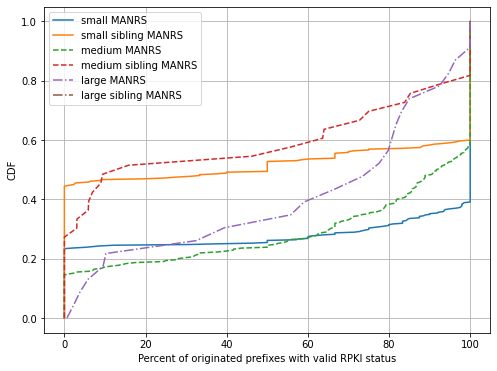

In [433]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_manrs_origin_rpki)), label='small MANRS', linestyle='-')
plt.plot(np.sort(small_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_sibling_non_manrs_origin_rpki)), label='small sibling MANRS', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_rpki)), label='medium MANRS', linestyle='--')
plt.plot(np.sort(medium_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_sibling_non_manrs_origin_rpki)), label='medium sibling MANRS', linestyle='--')
plt.plot(np.sort(large_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_manrs_origin_rpki)), label='large MANRS', linestyle='-.')
plt.plot(np.sort(large_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_sibling_non_manrs_origin_rpki)), label='large sibling MANRS', linestyle='-.')
plt.xlabel('Percent of originated prefixes with valid RPKI status')
plt.ylabel('CDF')
#plt.xlim(80, 105)
plt.legend()
plt.grid()

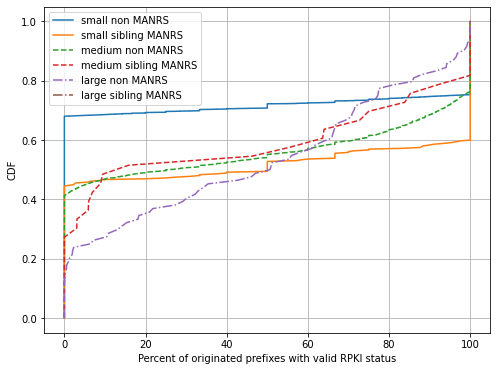

In [934]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_rpki)), label='small non MANRS', linestyle='-')
plt.plot(np.sort(small_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_sibling_non_manrs_origin_rpki)), label='small sibling MANRS', linestyle='-')
plt.plot(np.sort(medium_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_rpki)), label='medium non MANRS', linestyle='--')
plt.plot(np.sort(medium_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_sibling_non_manrs_origin_rpki)), label='medium sibling MANRS', linestyle='--')
plt.plot(np.sort(large_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_rpki)), label='large non MANRS', linestyle='-.')
plt.plot(np.sort(large_sibling_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_sibling_non_manrs_origin_rpki)), label='large sibling MANRS', linestyle='-.')
plt.xlabel('Percent of originated prefixes with valid RPKI status')
plt.ylabel('CDF')
#plt.xlim(80, 105)
plt.legend()
plt.grid()

In [435]:
large_sibling_non_manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent
1598,4826,0,0,114,83,42.13198,42.13198


In [752]:
large_manrs_origin_rpki['totalPO'] = large_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1)
large_non_manrs_origin_rpki['totalPO'] = large_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1)

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### How many RPKI valids, invalids do each type of networks originate?

#### small networks

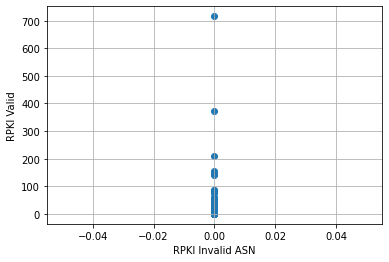

In [436]:
plt.scatter(small_manrs_origin_rpki['Invalid'], small_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid ASN')
plt.ylabel('RPKI Valid')
plt.grid()

who?? 19115 charter; Forhosting NL

In [437]:
small_manrs_origin_rpki[small_manrs_origin_rpki.Invalid > 0]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent


In [438]:
manrs_origin[manrs_origin.originasn_id.isin([19115, 142419]) & (manrs_origin.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype


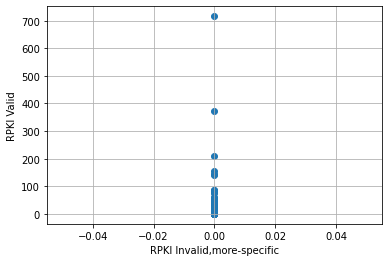

In [439]:
plt.scatter(small_manrs_origin_rpki['Invalid,more-specific'], small_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid,more-specific')
plt.ylabel('RPKI Valid')
plt.grid()

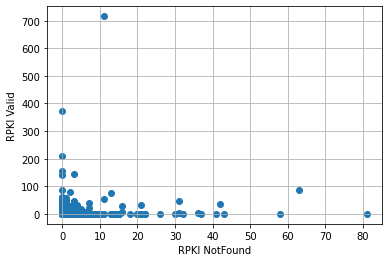

In [440]:
plt.scatter(small_manrs_origin_rpki['NotFound'], small_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI NotFound')
plt.ylabel('RPKI Valid')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()

In [989]:
large_non_manrs_origin[(large_non_manrs_origin
                       .rpki_status == 'Invalid') | (large_non_manrs_origin
                       .rpki_status == 'Invalid,more-specific')]['originasn_id'].nunique()

28

In [988]:
large_non_manrs_origin['originasn_id'].nunique()

85

In [985]:
198/4395

0.04505119453924915

#### medium networks

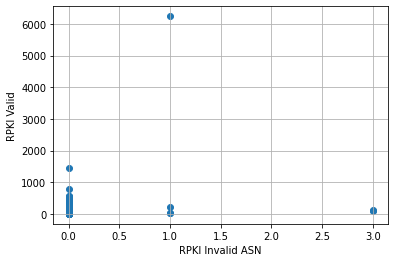

In [441]:
plt.scatter(medium_manrs_origin_rpki['Invalid'], medium_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid ASN')
plt.ylabel('RPKI Valid')
plt.grid()

In [981]:
medium_manrs_origin['originasn_id'].nunique()

311

In [982]:
9/311

0.028938906752411574

In [971]:
med_invalid_ASN = medium_manrs_origin_rpki[medium_manrs_origin_rpki.Invalid > 0]['originasn_id']
for i in med_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

10021 Colt Technology Services
16509 Amazon Web Services
20940 Akamai Technologies
23688 Link3 Technologies Ltd.
33659 Comcast
52468 Ufinet


In [443]:
manrs_origin[manrs_origin.originasn_id.isin(med_invalid_ASN) & (manrs_origin.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
705730,1415683351,2022-05-01 00:00:00+00,200.60.190.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,Proxy-registered route object,f,20940,PE,20940,CDN
705744,1415683337,2022-05-01 00:00:00+00,200.60.136.0/23,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN
1525613,1414863520,2022-05-01 00:00:00+00,154.215.1.0/24,0.115646,4,16.939891,Invalid,Valid,assigned,assigned,"funglr, Inc.",f,10021,HK,10021,ISP
1539864,1414849266,2022-05-01 00:00:00+00,130.156.192.0/20,0.346939,4,34.972678,Invalid,Invalid,assigned,assigned,"NJEDge.Net INC\n625 Broad Street, Suite 260\nN...",f,33659,US,33659,ISP
1968948,1414420163,2022-05-01 00:00:00+00,103.9.104.0/24,0.639456,4,50.819672,Invalid,Invalid,assigned,assigned,route object for 103.9.104.0/24,f,23688,BD,23688,ISP
1969760,1414419749,2022-05-01 00:00:00+00,170.82.39.0/24,0.646259,4,50.819672,Invalid,Valid,assigned,assigned,UFINET HONDURAS S.A,t,52468,HN,52468,ISP
2120580,1414267989,2022-05-01 00:00:00+00,103.9.104.0/23,0.639456,4,50.819672,Invalid,Invalid,assigned,assigned,route object for 103.9.104.0/23,f,23688,BD,23688,ISP
3484956,1412903885,2022-05-01 00:00:00+00,200.60.136.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN
3486203,1412903306,2022-05-01 00:00:00+00,158.51.108.0/24,0.489796,4,40.983607,Invalid,Valid,assigned,assigned,Amazon EC2 Prefix,f,16509,US,16509,CDN
3494986,1412893665,2022-05-01 00:00:00+00,103.9.105.0/24,0.639456,4,50.819672,Invalid,Invalid,assigned,assigned,route object for 103.9.105.0/24,f,23688,BD,23688,ISP


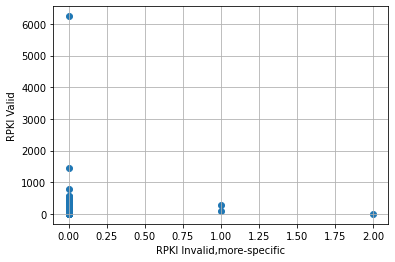

In [444]:
plt.scatter(medium_manrs_origin_rpki['Invalid,more-specific'], medium_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid,more-specific')
plt.ylabel('RPKI Valid')
plt.grid()

In [445]:
med_invalid_len = medium_manrs_origin_rpki[medium_manrs_origin_rpki['Invalid,more-specific'] > 0]['originasn_id']
for i in med_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

23674 Nayatel Pvt. Ltd
28294 Univox
48362 Stadtwerke Feldkirch


In [446]:
manrs_origin[manrs_origin.originasn_id.isin(med_invalid_len) & (manrs_origin.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
718348,1415670555,2022-05-01 00:00:00+00,92.249.22.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,NaN,f,48362,AT,48362,ISP
1526355,1414862791,2022-05-01 00:00:00+00,101.50.84.0/22,0.387755,4,36.612022,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Nayatel Route Object 101.50.64.0/18,f,23674,PK,23674,ISP
1549420,1414839426,2022-05-01 00:00:00+00,179.107.208.0/21,0.435374,4,40.983607,"Invalid,more-specific",Valid,assigned,assigned,Univox,f,28294,BR,28294,ISP
1963005,1414426153,2022-05-01 00:00:00+00,92.249.20.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,NaN,f,48362,AT,48362,ISP


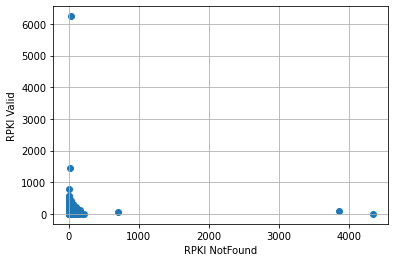

In [447]:
plt.scatter(medium_manrs_origin_rpki['NotFound'], medium_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI NotFound')
plt.ylabel('RPKI Valid')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()

#### large networks

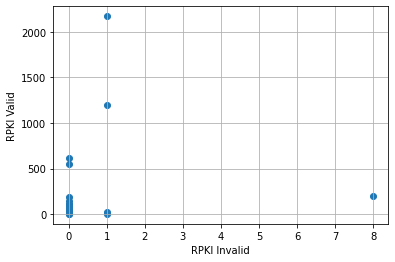

In [448]:
plt.scatter(large_manrs_origin_rpki['Invalid'], large_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid')
plt.ylabel('RPKI Valid')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()

In [449]:
large_invalid_ASN = large_manrs_origin_rpki[large_manrs_origin_rpki.Invalid > 0]['originasn_id']
for i in large_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

174 Cogent Communications Inc.
3356 CenturyLink
3549 CenturyLink
13335 Cloudflare
20115 Charter Communications


In [450]:
manrs_origin[manrs_origin.originasn_id.isin(large_invalid_ASN) & (manrs_origin.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
699120,1415689926,2022-05-01 00:00:00+00,178.171.100.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,GB,174,ISP
717770,1415671250,2022-05-01 00:00:00+00,212.69.135.0/24,0.061224,4,13.661202,Invalid,Invalid,assigned,assigned,NaN,t,174,TR,174,ISP
719522,1415669945,2022-05-01 00:00:00+00,45.172.187.0/24,0.210884,4,24.590164,Invalid,Invalid,assigned,assigned,NaN,f,3549,CO,3549,ISP
1545909,1414843588,2022-05-01 00:00:00+00,45.84.242.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,US,174,ISP
1557276,1414831811,2022-05-01 00:00:00+00,216.173.83.0/24,0.061224,4,14.207650,Invalid,Invalid,assigned,assigned,H4Y Technologies LLC,t,174,US,174,ISP
2114870,1414274639,2022-05-01 00:00:00+00,98.154.77.0/24,0.006803,4,8.743169,Invalid,Invalid,assigned,assigned,RR-Route,t,20115,US,20115,ISP
2121627,1414268231,2022-05-01 00:00:00+00,85.239.55.0/24,0.700680,4,56.830601,Invalid,Invalid,assigned,assigned,NaN,f,174,RU,174,ISP
2121642,1414268216,2022-05-01 00:00:00+00,45.84.243.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,US,174,ISP
4346576,1412042289,2022-05-01 00:00:00+00,103.21.244.0/24,0.687075,4,56.284153,Invalid,"Invalid,more-specific",assigned,assigned,"Cloudflare Hong Kong, LLC\n101 Townsend Street",f,13335,US,13335,CDN
4537577,1411851404,2022-05-01 00:00:00+00,47.19.10.0/24,0.646259,4,52.459016,Invalid,Invalid,assigned,assigned,BayNetworks\nNortelNetworks\n4401 Great Americ...,f,174,US,174,ISP


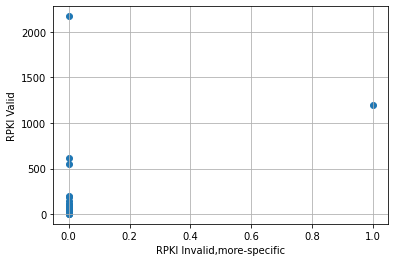

In [451]:
plt.scatter(large_manrs_origin_rpki['Invalid,more-specific'], large_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI Invalid,more-specific')
plt.ylabel('RPKI Valid')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()

In [452]:
large_non_manrs_origin_rpki

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent
106,209,0,0,2463,58,2.300674,2.300674
235,577,0,0,675,0,0.000000,0.000000
269,701,0,0,1003,122,10.844444,10.844444
270,702,0,0,196,2,1.010101,1.010101
314,852,0,1,450,214,32.330827,32.180451
391,1239,1,0,277,1714,86.094378,86.044177
398,1257,0,0,429,50,10.438413,10.438413
405,1273,0,40,174,48,33.587786,18.320611
917,2828,0,0,112,0,0.000000,0.000000
936,2856,1,0,229,113,33.236152,32.944606


In [453]:
large_invalid_len = large_manrs_origin_rpki[large_manrs_origin_rpki['Invalid,more-specific'] > 0]['originasn_id']
for i in large_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

13335 Cloudflare


In [454]:
manrs_origin[manrs_origin.originasn_id.isin(large_invalid_len) & (manrs_origin.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
1963043,1414426058,2022-05-01 00:00:00+00,172.68.83.0/24,0.129252,4,18.579235,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"101 Townsend Street, San Francisco, California...",f,13335,US,13335,CDN


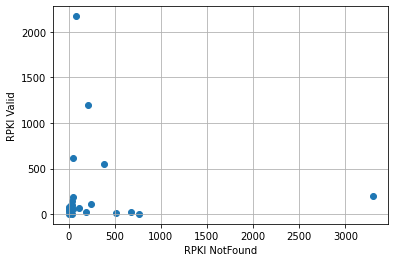

In [455]:
plt.scatter(large_manrs_origin_rpki['NotFound'], large_manrs_origin_rpki['Valid'])
plt.xlabel('RPKI NotFound')
plt.ylabel('RPKI Valid')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2becb9e790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2becb9eeb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2becb9e400>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2becb94610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2becb949a0>],
 'means': []}

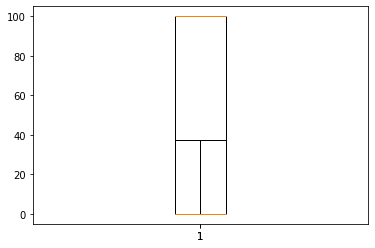

In [456]:
plt.boxplot(small_manrs_origin_rpki['rpki_percent'])
plt.boxplot(small_non_manrs_origin_rpki['rpki_percent'])

## IRR

### Does MANRS networks originate more prefixes with IRR record?

In [457]:
manrs_origin_irr = manrs_origin.groupby(['originasn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
manrs_origin_irr['irr_percent'] = (1-manrs_origin_irr['NotFound']/manrs_origin_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [458]:
non_manrs_origin_irr = non_manrs_origin.groupby(['originasn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
non_manrs_origin_irr['irr_percent'] = (1-non_manrs_origin_irr['NotFound']/non_manrs_origin_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

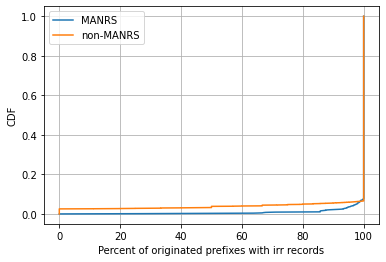

In [459]:
plt.plot(np.sort(manrs_origin_irr['irr_percent']), np.linspace(0,1,len(manrs_origin_irr)), label='MANRS')
plt.plot(np.sort(non_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(non_manrs_origin_irr)), label='non-MANRS')
plt.xlabel('Percent of originated prefixes with irr records')
plt.ylabel('CDF')
plt.legend()
plt.grid()

In [460]:
small_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(small)]
medium_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(medium)]
large_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(large)]
small_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(small)]
medium_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(medium)]
large_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(large)]

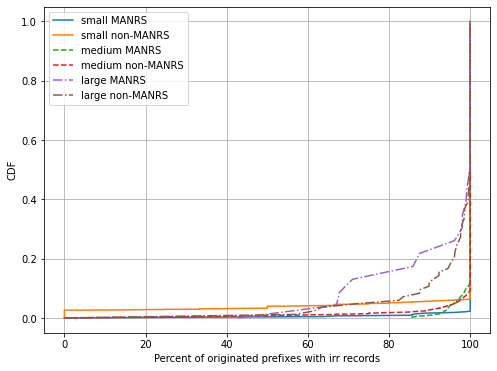

In [461]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(small_manrs_origin_irr)), label='small MANRS', linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(small_non_manrs_origin_irr)), label='small non-MANRS', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(medium_manrs_origin_irr)), label='medium MANRS', linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(medium_non_manrs_origin_irr)), label='medium non-MANRS', linestyle='--')
plt.plot(np.sort(large_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(large_manrs_origin_irr)), label='large MANRS', linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_irr['irr_percent']), np.linspace(0,1,len(large_non_manrs_origin_irr)), label='large non-MANRS', linestyle='-.')
plt.xlabel('Percent of originated prefixes with irr records')
plt.ylabel('CDF')
plt.legend()
plt.grid()

### Does MANRS originate more irr valids than non_MANRS?

In [462]:
manrs_origin_irr['valid_percent'] = (manrs_origin_irr['Valid']/manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
non_manrs_origin_irr['valid_percent'] = (non_manrs_origin_irr['Valid']/non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100


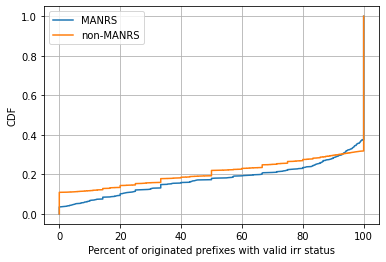

In [463]:
plt.plot(np.sort(manrs_origin_irr['valid_percent'].dropna()), np.linspace(0,1,len(manrs_origin_irr['valid_percent'].dropna())), label='MANRS')
plt.plot(np.sort(non_manrs_origin_irr['valid_percent'].dropna()), np.linspace(0,1,len(non_manrs_origin_irr['valid_percent'].dropna())), label='non-MANRS')
plt.xlabel('Percent of originated prefixes with valid irr status')
plt.ylabel('CDF')
plt.legend()
plt.grid()

In [913]:
small_manrs_origin_irr['valid_percent'] = (small_manrs_origin_irr['Valid']/small_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
small_non_manrs_origin_irr['valid_percent'] = (small_non_manrs_origin_irr['Valid']/small_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

medium_manrs_origin_irr['valid_percent'] = (medium_manrs_origin_irr['Valid']/medium_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
medium_non_manrs_origin_irr['valid_percent'] = (medium_non_manrs_origin_irr['Valid']/medium_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

large_manrs_origin_irr['valid_percent'] = (large_manrs_origin_irr['Valid']/large_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
large_non_manrs_origin_irr['valid_percent'] = (large_non_manrs_origin_irr['Valid']/large_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [914]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

451 319 24


In [915]:
print(len(small_non_manrs), len(medium_non_manrs), len(large_non_manrs))

68383 4489 86


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


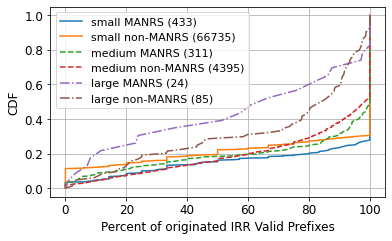

In [1019]:
plt.figure(figsize=(6,3.5))
plt.plot(np.sort(small_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(small_manrs_origin_irr)), label='small MANRS ({})'.format(len(small_manrs_origin_irr)), linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_irr)), label='small non-MANRS ({})'.format(len(small_non_manrs_origin_irr)), linestyle='-')
plt.plot(np.sort(medium_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_irr)), label='medium MANRS ({})'.format(len(medium_manrs_origin_irr)), linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_irr)), label='medium non-MANRS ({})'.format(len(medium_non_manrs_origin_irr)), linestyle='--')
plt.plot(np.sort(large_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(large_manrs_origin_irr)), label='large MANRS ({})'.format(len(large_manrs_origin_irr)), linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_irr)), label='large non-MANRS ({})'.format(len(large_non_manrs_origin_irr)), linestyle='-.')
plt.xlabel('Percent of originated IRR Valid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':11})
plt.grid()
plt.savefig('manrsoriginirr.eps', bbox_inches='tight')

In [917]:
len(manrscdn)

21

In [918]:
18/21

0.8571428571428571

In [910]:
medium_manrs_origin_irr

irr_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,irr_percent,valid_percent
3,101,0,0,0,4,100.0,100.0
6,137,0,0,0,82,100.0,100.0
9,237,0,0,0,43,100.0,100.0
10,271,0,0,0,58,100.0,100.0
12,293,0,0,0,12,100.0,100.0
...,...,...,...,...,...,...,...
694,266525,1,0,0,3,100.0,75.0
696,266968,0,2,0,1,100.0,100.0
709,267562,0,0,0,7,100.0,100.0
757,328594,0,0,0,15,100.0,100.0


In [911]:
large_non_manrs_origin_irr.describe()

irr_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,irr_percent,valid_percent
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,19593.341176,67.211765,241.623529,22.517647,432.917647,95.210289,87.488009
std,36964.537688,191.966273,832.150470,95.476576,837.816013,13.375083,21.374009
min,209.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4637.000000,0.000000,3.000000,0.000000,56.000000,96.787149,87.373737
50%,8218.000000,4.000000,20.000000,1.000000,167.000000,99.974696,96.659708
75%,20764.000000,43.000000,110.000000,9.000000,332.000000,100.000000,99.730458
max,262589.000000,1319.000000,6682.000000,849.000000,4818.000000,100.000000,100.000000


In [912]:
medium_manrs_origin_irr['valid_percent'].value_counts()

100.000000    239
0.000000        8
98.989899       2
81.632653       2
85.714286       2
8.333333        1
22.222222       1
99.715100       1
96.521739       1
95.652174       1
25.000000       1
97.560976       1
1.666667        1
95.143488       1
35.483871       1
16.666667       1
4.444444        1
5.633803        1
5.263158        1
10.416667       1
2.564103        1
2.500000        1
4.878049        1
98.888889       1
84.313725       1
73.529412       1
93.750000       1
99.541284       1
71.428571       1
96.774194       1
78.571429       1
93.333333       1
97.653293       1
98.820905       1
99.487179       1
99.230769       1
93.814433       1
98.601399       1
94.230769       1
98.765432       1
90.909091       1
95.333333       1
99.603699       1
99.907940       1
98.675497       1
99.655172       1
88.571429       1
3.921569        1
17.073171       1
94.652406       1
96.000000       1
59.872611       1
99.549550       1
99.472759       1
87.730061       1
83.783784 

In [775]:
313/433

0.7228637413394919

In [778]:
46420/66735

0.6955870233011163

In [784]:
162/311

0.5209003215434084

In [781]:
2109/4395

0.47986348122866895

## IRR-only ASes

In [997]:
small_manrs_irr_only = small_manrs_origin_irr[['originasn_id','irr_percent']].merge(small_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
small_non_manrs_irr_only = small_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(small_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


medium_manrs_irr_only = medium_manrs_origin_irr[['originasn_id','irr_percent']].merge(medium_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
medium_non_manrs_irr_only = medium_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(medium_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


large_manrs_irr_only = large_manrs_origin_irr[['originasn_id','irr_percent']].merge(large_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
large_non_manrs_irr_only = large_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(large_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


In [1001]:
small_manrs_irr_only[(small_manrs_irr_only.irr_percent > 0) & (small_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
3,103,100.0,0.0,0.0
4,111,100.0,0.0,0.0
5,160,100.0,0.0,0.0
21,5503,100.0,0.0,0.0
22,6509,100.0,0.0,0.0
...,...,...,...,...
416,328259,100.0,0.0,0.0
418,328271,100.0,0.0,0.0
422,328582,100.0,0.0,0.0
426,394989,100.0,0.0,0.0


In [1007]:
small_manrs_origin['originasn_id'].nunique()

433

In [1008]:
102/433

0.23556581986143188

In [1002]:
small_non_manrs_irr_only[(small_non_manrs_irr_only.irr_percent > 0) & (small_non_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
0,1,80.0,0.0,0.0
5,6,100.0,0.0,0.0
6,7,100.0,0.0,0.0
9,10,100.0,0.0,0.0
10,12,100.0,0.0,0.0
...,...,...,...,...
66729,400439,100.0,0.0,0.0
66730,400453,100.0,0.0,0.0
66731,400454,100.0,0.0,0.0
66732,400473,100.0,0.0,0.0


In [1009]:
43659/66735

0.6542144302090357

In [1010]:
len(medium_manrs_irr_only[(medium_manrs_irr_only.irr_percent > 0) & (medium_manrs_irr_only.rpki_percent == 0)])

46

In [1012]:
46/311

0.14790996784565916

In [1005]:
medium_non_manrs_irr_only[(medium_non_manrs_irr_only.irr_percent > 0) & (medium_non_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
2,62,100.00000,0.0,0.0
3,71,91.37931,0.0,0.0
4,81,100.00000,0.0,0.0
5,195,100.00000,0.0,0.0
6,202,100.00000,0.0,0.0
...,...,...,...,...
4382,396300,100.00000,0.0,0.0
4384,396926,100.00000,0.0,0.0
4391,398563,100.00000,0.0,0.0
4393,399559,100.00000,0.0,0.0


In [1013]:
1803/4395

0.41023890784982936

In [1004]:
large_manrs_irr_only[(large_manrs_irr_only.irr_percent > 0) & (large_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent


In [1006]:
large_non_manrs_irr_only[(large_non_manrs_irr_only.irr_percent > 0) & (large_non_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
1,577,87.555556,0.0,0.0
8,2828,87.500000,0.0,0.0
10,3216,100.000000,0.0,0.0
12,3255,100.000000,0.0,0.0
41,8167,100.000000,0.0,0.0
50,9318,100.000000,0.0,0.0
66,23106,100.000000,0.0,0.0
68,29076,100.000000,0.0,0.0
69,29226,100.000000,0.0,0.0
81,61832,100.000000,0.0,0.0


In [1016]:
10/85

0.11764705882352941

## IRR or RPKI

In [468]:
def irr_or_rpki(r):
    if r['irr_status'] == 'Valid' or r['rpki_status'] == 'Valid' or r['irr_status'] == 'Invalid,more-specific':
        return True
    return False

In [469]:
def irr_or_rpki_strict(r):
    if r['irr_status'] == 'Valid' or r['rpki_status'] == 'Valid':
        return True
    return False

In [470]:
manrs_origin['either_status'] = manrs_origin.apply(irr_or_rpki, axis=1)

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [471]:
non_manrs_origin['either_status'] = non_manrs_origin.apply(irr_or_rpki, axis=1)

In [472]:
manrs_origin_either = manrs_origin.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

In [473]:
manrs_origin_either[manrs_origin_either.originasn_id == 8075]

either_status,originasn_id,False,True
100,8075,0,222


In [474]:
8075 in manrscdn

True

In [475]:
set(manrs).intersection(set(manrscdn))

{7342, 8075, 8280, 15169, 50520}

In [476]:
non_manrs_origin_either = non_manrs_origin.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

In [477]:
manrs_origin_either[manrs_origin_either[False] > 0]

either_status,originasn_id,False,True
8,174,1283,2231
11,278,3,143
13,376,10,177
14,553,5,92
18,680,2,284
20,1103,1,98
23,1221,146,214
25,1299,4,132
27,1653,3,49
30,1916,2,160


In [478]:
manrs_origin_either['valid_percent'] = manrs_origin_either[True]/(manrs_origin_either[False] + manrs_origin_either[True])*100

In [479]:
non_manrs_origin_either['valid_percent'] = non_manrs_origin_either[True]/(non_manrs_origin_either[False] + non_manrs_origin_either[True])*100

In [480]:
small_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(small)]
medium_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(medium)]
large_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(large)]
small_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(small)]
medium_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(medium)]
large_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(large)]

### scatter plot: # compliant pfx vs # non-compliant pfx

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


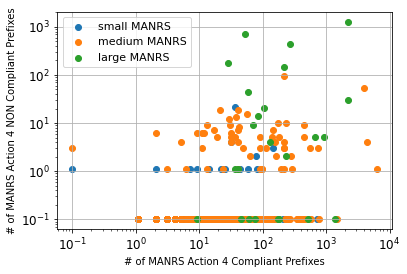

In [481]:
plt.scatter(manrs_origin_either[manrs_origin_either.originasn_id.isin(small_manrs)][True]+0.1, manrs_origin_either[manrs_origin_either.originasn_id.isin(small_manrs)][False]+0.1, label='small MANRS')
plt.scatter(manrs_origin_either[manrs_origin_either.originasn_id.isin(medium_manrs)][True]+0.1, manrs_origin_either[manrs_origin_either.originasn_id.isin(medium_manrs)][False]+0.1, label='medium MANRS')
plt.scatter(manrs_origin_either[manrs_origin_either.originasn_id.isin(large_manrs)][True]+0.1, manrs_origin_either[manrs_origin_either.originasn_id.isin(large_manrs)][False]+0.1, label='large MANRS')
plt.xlabel('# of MANRS Action 4 Compliant Prefixes')
plt.ylabel('# of MANRS Action 4 NON Compliant Prefixes')
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':11})
plt.grid()
plt.savefig('manrs4compliantscatter.eps', bbox_inches='tight')

consider irr invalid more specific as valid

In [482]:
manrs_origin_either[manrs_origin_either[True] == 0]

either_status,originasn_id,False,True,valid_percent
318,33665,1,0,0.0
319,33666,3,0,0.0


In [483]:
manrs_origin[manrs_origin.originasn_id==271915]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
2342005,1414047477,2022-05-01 00:00:00+00,38.87.203.0/24,1.0,4,100.000000,NotFound,Valid,assigned,assigned,"SIMEON IPv4 Network, delegated from COGENT",f,271915,US,271915,ISP,True
2726820,1413662689,2022-05-01 00:00:00+00,38.87.200.0/24,1.0,4,100.000000,NotFound,Valid,assigned,assigned,"SIMEON IPv4 Network, delegated from COGENT",f,271915,US,271915,ISP,True
2881240,1413507739,2022-05-01 00:00:00+00,38.87.200.0/22,1.0,4,100.000000,NotFound,Valid,assigned,assigned,"SIMEON IPv4 Network, delegated from COGENT",f,271915,US,271915,ISP,True
3689660,1412699460,2022-05-01 00:00:00+00,38.87.202.0/24,1.0,4,99.453552,NotFound,Valid,assigned,assigned,"SIMEON IPv4 Network, delegated from COGENT",f,271915,US,271915,ISP,True
4177841,1412211668,2022-05-01 00:00:00+00,38.87.201.0/24,1.0,4,99.453552,NotFound,Valid,assigned,assigned,"SIMEON IPv4 Network, delegated from COGENT",f,271915,US,271915,ISP,True


### CDF: percentage of compliant networks

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


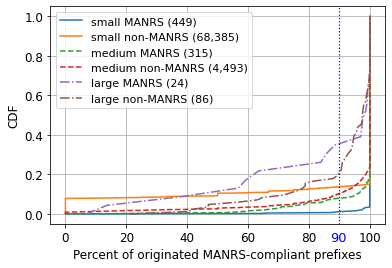

In [652]:
plt.plot(np.sort(small_manrs_origin_either['valid_percent']), np.linspace(0,1,len(small_manrs_origin_either)), label='small MANRS (449)', linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_either['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_either)), label='small non-MANRS (68,385)', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_either['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_either)), label='medium MANRS (315)', linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_either['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_either)), label='medium non-MANRS (4,493)', linestyle='--')
plt.plot(np.sort(large_manrs_origin_either['valid_percent']), np.linspace(0,1,len(large_manrs_origin_either)), label='large MANRS (24)', linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_either['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_either)), label='large non-MANRS (86)', linestyle='-.')
plt.axvline(x=90, linestyle=':', color='blue', linewidth=1.25)
plt.text(87, -0.14, '90', color='blue', size=13)
plt.xlabel('Percent of originated MANRS-compliant prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':11})
plt.grid()
plt.savefig('manrsorigineither.eps', bbox_inches='tight')

In [485]:
manrs_origin_either['90_compliant'] = manrs_origin_either.apply(lambda x: x[True]/(x[True]+x[False]), axis=1)

In [486]:
manrs_origin_either[manrs_origin_either['90_compliant'] < 0.9].sort_values('90_compliant', ascending=True)

either_status,originasn_id,False,True,valid_percent,90_compliant
319,33666,3,0,0.000000,0.000000
318,33665,1,0,0.000000,0.000000
55,3549,719,53,6.865285,0.068653
78,6461,177,28,13.658537,0.136585
253,27750,6,2,25.000000,0.250000
53,3356,439,268,37.906648,0.379066
320,33667,19,21,52.500000,0.525000
219,22258,4,5,55.555556,0.555556
82,7015,45,59,56.730769,0.567308
306,33490,9,13,59.090909,0.590909


In [487]:
len(manrs_origin_either[manrs_origin_either['90_compliant'] < 0.9])

39

In [ ]:
manrs

### compliance vs age

In [488]:
as_entry_df = pd.read_csv('manrs_entry_date.csv.gz')

In [489]:
as_entry_df['asn'] = as_entry_df['asn'].apply(int)

In [490]:
manrs_origin_either = manrs_origin_either.merge(as_entry_df, left_on='originasn_id', right_on='asn', how='left')

In [491]:
def delta_date(x):
    if pd.isnull(x):
        return
    x = datetime.strptime(x, '%Y-%m-%d')
    y = datetime.strptime('2022-04-27', '%Y-%m-%d')
    return (y-x).days

In [492]:
manrs_origin_either['age'] = manrs_origin_either['date'].apply(delta_date)

In [493]:
manrs_origin_either

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age
0,87,0,17,100.0,1.0,87.0,2018-08-08,ARIN,1358.0
1,88,0,10,100.0,1.0,88.0,2019-07-16,ARIN,1016.0
2,92,0,4,100.0,1.0,92.0,2021-10-17,ARIN,192.0
3,101,0,4,100.0,1.0,NaN,NaN,NaN,NaN
4,103,0,22,100.0,1.0,103.0,2019-03-13,ARIN,1141.0
...,...,...,...,...,...,...,...,...,...
764,395262,0,1,100.0,1.0,395262.0,2020-07-06,ARIN,660.0
765,396955,1,9,90.0,0.9,NaN,NaN,NaN,NaN
766,396961,0,5,100.0,1.0,NaN,NaN,NaN,NaN
767,398866,0,2,100.0,1.0,398866.0,2021-03-11,ARIN,412.0


In [494]:
manrs_origin_either[manrs_origin_either.originasn_id==2914]

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age
47,2914,2,231,99.141631,0.991416,2914.0,2014-11-01,ARIN,2734.0


In [532]:
manrs_origin_either[(manrs_origin_either.originasn_id.isin(manrscdn))].sort_values(False, ascending=False)

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org
208,20940,53,3910,98.662629,0.986626,20940.0,2020-04-01,RIPE,756.0,Akamai Technologies
205,20473,5,919,99.458874,0.994589,20473.0,2020-04-01,ARIN,756.0,Vultr
187,16509,1,6275,99.984066,0.999841,16509.0,2020-04-01,ARIN,756.0,Amazon Web Services
46,2906,0,154,100.000000,1.000000,2906.0,2020-04-01,ARIN,756.0,Netflix
425,50520,0,5,100.000000,1.000000,50520.0,2020-04-13,RIPE,744.0,Hostmein IKE
534,135337,0,5,100.000000,1.000000,135337.0,2020-04-01,APNIC,756.0,Cloud Himalaya Pvt LTd
530,133800,0,49,100.000000,1.000000,133800.0,2020-04-01,APNIC,756.0,Biznet Gio
488,59414,0,9,100.000000,1.000000,59414.0,2020-04-01,RIPE,756.0,cloudscale.ch
470,55095,0,17,100.000000,1.000000,55095.0,2020-04-01,ARIN,756.0,Netflix
467,54825,0,120,100.000000,1.000000,54825.0,2020-04-01,ARIN,756.0,Equinix Metal


In [920]:
set(manrscdn) - set(manrs_origin_either[(manrs_origin_either.originasn_id.isin(manrscdn))]['originasn_id'])

{8074}

In [922]:
len(manrs)

849

In [925]:
849-754+715

810

In [926]:
810/849

0.9540636042402827

In [927]:
(3+1+8+1)/(48+5+302+272+486+3+1+8+1)

0.011545293072824156

In [896]:
xcdn = manrs_origin_either[(manrs_origin_either.originasn_id.isin(manrscdn)) & (manrs_origin_either.valid_percent < 100)]['originasn_id']

In [897]:
xisp = manrs_origin_either[(manrs_origin_either.originasn_id.isin(manrs)) & (manrs_origin_either.valid_percent < 90)]['originasn_id']


In [902]:
call = set(manrsas) - set(xcdn).union(set(xisp))

In [905]:
with open('action4.txt', 'wt') as f:
    for i in call:
        f.write(str(i))
        f.write('\n')

In [789]:
manrs_origin_either[manrs_origin_either.originasn_id.isin(manrs)]

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org,years
0,87,0,17,100.0,1.0,87.0,2018-08-08,ARIN,1358.0,Indiana University,3.720548
1,88,0,10,100.0,1.0,88.0,2019-07-16,ARIN,1016.0,Princeton University,2.783562
2,92,0,4,100.0,1.0,92.0,2021-10-17,ARIN,192.0,Clarkson University,0.526027
3,101,0,4,100.0,1.0,NaN,NaN,NaN,NaN,Pacific Northwest Gigapop,NaN
4,103,0,22,100.0,1.0,103.0,2019-03-13,ARIN,1141.0,Northwestern University,3.126027
...,...,...,...,...,...,...,...,...,...,...,...
764,395262,0,1,100.0,1.0,395262.0,2020-07-06,ARIN,660.0,CENGN,1.808219
765,396955,1,9,90.0,0.9,NaN,NaN,NaN,NaN,Internet2,NaN
766,396961,0,5,100.0,1.0,NaN,NaN,NaN,NaN,Internet2,NaN
767,398866,0,2,100.0,1.0,398866.0,2021-03-11,ARIN,412.0,InterBank,1.128767


In [791]:
17/20

0.85

In [790]:
715/754

0.9482758620689655

In [498]:
small_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(small)]
medium_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(medium)]
large_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(large)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


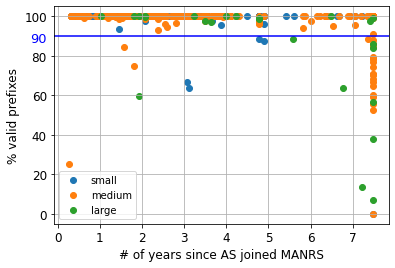

In [703]:
plt.scatter(small_manrs_origin_either['age']/365, small_manrs_origin_either['valid_percent'], label='small')
plt.scatter(medium_manrs_origin_either['age']/365, medium_manrs_origin_either['valid_percent'], label='medium')
plt.scatter(large_manrs_origin_either['age']/365, large_manrs_origin_either['valid_percent'], label='large')
plt.xlabel('# of years since AS joined MANRS', fontsize=12)
plt.ylabel('% valid prefixes', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=90, linestyle='-', color='blue', linewidth=1.5)
plt.text(-0.65, 87, '90', color='blue', size=13)
plt.legend(prop={'size':10})
plt.grid()
plt.savefig('manrscomplianceage.eps', bbox_inches='tight')

In [705]:
manrs_origin_either['years'] = manrs_origin_either['age']/365

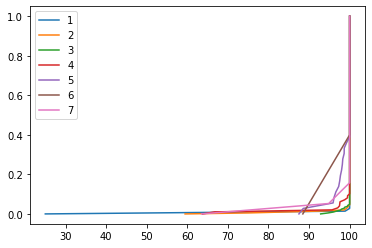

In [710]:
for i in range(1,8):
    plt.plot(np.sort(manrs_origin_either[(manrs_origin_either.years <= i) & (manrs_origin_either.years > i-1)]['valid_percent']), np.linspace(0,1,len(manrs_origin_either[(manrs_origin_either.years <= i) & (manrs_origin_either.years > i-1)])), label=str(i))
plt.legend()
    

### organization level compliance

In [501]:
manrs_origin_either['org'] = manrs_origin_either['originasn_id'].apply(lambda x: manrs_org[x])

In [502]:
def org_level_compliance(l):
    return len(l[l>=90])/len(l) >= 0.5

In [503]:
org_compliance = manrs_origin_either.groupby('org').agg({'valid_percent': org_level_compliance, 'age':'first'})

In [504]:
org_compliance[org_compliance.valid_percent == False]

,valid_percent,age
org,,
CenturyLink,False,2734.0
Cogent Communications Inc.,False,2469.0
Comcast,False,2734.0
MAXNET,False,659.0
Net Barretos,False,1135.0
Orange - Open Transit Internet,False,2037.0
RedCLARA,False,98.0
Saskatchewan Research Network Inc. (SRNET,False,NaN
Sky,False,2690.0


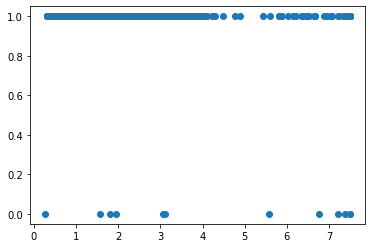

In [505]:
plt.scatter(org_compliance['age']/365, org_compliance['valid_percent'])

In [506]:
manrs_origin_either[manrs_origin_either.org == 'Comcast'].sum()

originasn_id                                                749021
False                                                          337
True                                                           972
valid_percent                                          1987.495613
90_compliant                                             19.874956
asn                                                       749021.0
date             2014-11-012014-11-012014-11-012014-11-012014-1...
rir              ARINARINARINARINARINARINARINARINARINARINARINAR...
age                                                        76552.0
org              ComcastComcastComcastComcastComcastComcastComc...
dtype: object

would comcast be compliant if MANRS allows sibling?

#### comcast case

In [507]:
comcast = manrs_origin_either[manrs_origin_either.org == 'Comcast']

In [655]:
manrs_origin[manrs_origin.prefix == '104.243.67.0/24']

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
5165310,1411223304,2022-05-01 00:00:00+00,104.243.67.0/24,1.0,4,100.0,NotFound,Invalid,assigned,assigned,EZZI.net ROUTE,f,7922,US,7922,ISP,False


In [541]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Comcast'])]

either_status,originasn_id,False,True,valid_percent
69607,395974,0,1,100.0
69609,395976,0,1,100.0
69612,395980,0,1,100.0
69636,396017,0,1,100.0
69638,396019,0,1,100.0
69640,396021,0,5,100.0


In [630]:
comcast[comcast.valid_percent < 90]

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org
82,7015,45,59,56.730769,0.567308,7015.0,2014-11-01,ARIN,2734.0,Comcast
83,7016,13,38,74.509804,0.745098,7016.0,2014-11-01,ARIN,2734.0,Comcast
90,7725,5,36,87.804878,0.878049,7725.0,2014-11-01,ARIN,2734.0,Comcast
98,7922,94,220,70.063694,0.700637,7922.0,2014-11-01,ARIN,2734.0,Comcast
160,13367,6,9,60.000000,0.600000,13367.0,2014-11-01,ARIN,2734.0,Comcast
204,20214,6,32,84.210526,0.842105,20214.0,2014-11-01,ARIN,2734.0,Comcast
213,21508,7,17,70.833333,0.708333,21508.0,2014-11-01,ARIN,2734.0,Comcast
219,22258,4,5,55.555556,0.555556,22258.0,2014-11-01,ARIN,2734.0,Comcast
225,22909,6,11,64.705882,0.647059,22909.0,2014-11-01,ARIN,2734.0,Comcast
303,33287,19,41,68.333333,0.683333,33287.0,2014-11-01,ARIN,2734.0,Comcast


In [509]:
manrs_origin[manrs_origin.originasn_id.isin(comcast.originasn_id)].groupby(['originasn_id', 'irr_status', 'rpki_status']).size().unstack(fill_value=0)

rpki_status                         Invalid  NotFound  Valid
originasn_id irr_status                                     
7015         Invalid                      0        43     58
             NotFound                     0         2      0
             Valid                        0         1      0
7016         Invalid                      0        10     36
             NotFound                     0         3      0
             Valid                        0         2      0
7725         Invalid                      0         5     29
             Valid                        0         7      0
7922         Invalid                      0        79     31
             Invalid,more-specific        0         0     10
             NotFound                     0        15      1
             Valid                        0         6    172
11025        Invalid                      0         0      2
             Invalid,more-specific        0         0      5
             Valid                        0         0      3
13367        Invalid                      0         5      9
             NotFound                     0         1      0
20214        Invalid                      0         6     30
             Valid                        0         2      0
21508        Invalid                      0         7     15
             Valid                        0         2      0
22258        Invalid                      0         4      3
             Valid                        0         2      0
22909        Invalid                      0         6     11
33287        Invalid                      0        17     40
             NotFound                     0         2      0
             Valid                        0         1      0
33489        Invalid                      0         3     11
33490        Invalid                      0         9     13
33491        Invalid                      0        20    103
             Invalid,more-specific        0         1      0
33650        Invalid                      0         3     25
             NotFound                     0         2      0
             Valid                        0         6      0
33651        Invalid                      0        13     76
             NotFound                     0         1      0
             Valid                        0         8      0
33652        Invalid                      0         2     39
             NotFound                     0         2      0
             Valid                        0         2      0
33654        Invalid                      0         0      1
33657        Invalid                      0        15     50
             NotFound                     0         0      2
             Valid                        0         4      0
33659        Invalid                      1         4     36
             NotFound                     0         2      0
             Valid                        0         5      0
33660        Invalid                      0         5     19
33661        Invalid                      0         5     12
             NotFound                     0         1      0
33662        Invalid                      0         7     29
             NotFound                     0         2      0
             Valid                        0         0      1
33665        Invalid                      0         1      0
33666        Invalid                      0         3      0
33667        Invalid                      0        18     20
             NotFound                     0         1      0
             Valid                        0         1      0
33668        Invalid                      0        11     27
             NotFound                     0         1      0
             Valid                        0         2      0
36733        Valid                        0         0      1

In [513]:
# manrs_origin[manrs_origin.originasn_id.isin(comcast.originasn_id)].to_csv('comcast_case.csv.gz')

In [511]:
manrs_origin[manrs_origin.originasn_id.isin(comcast.originasn_id)].groupby(['originasn_id', 'rpki_status', 'irr_status']).size().unstack(fill_value=0)

irr_status                Invalid  Invalid,more-specific  NotFound  Valid
originasn_id rpki_status                                                 
7015         NotFound          43                      0         2      1
             Valid             58                      0         0      0
7016         NotFound          10                      0         3      2
             Valid             36                      0         0      0
7725         NotFound           5                      0         0      7
             Valid             29                      0         0      0
7922         NotFound          79                      0        15      6
             Valid             31                     10         1    172
11025        Valid              2                      5         0      3
13367        NotFound           5                      0         1      0
             Valid              9                      0         0      0
20214        NotFound           6                      0         0      2
             Valid             30                      0         0      0
21508        NotFound           7                      0         0      2
             Valid             15                      0         0      0
22258        NotFound           4                      0         0      2
             Valid              3                      0         0      0
22909        NotFound           6                      0         0      0
             Valid             11                      0         0      0
33287        NotFound          17                      0         2      1
             Valid             40                      0         0      0
33489        NotFound           3                      0         0      0
             Valid             11                      0         0      0
33490        NotFound           9                      0         0      0
             Valid             13                      0         0      0
33491        NotFound          20                      1         0      0
             Valid            103                      0         0      0
33650        NotFound           3                      0         2      6
             Valid             25                      0         0      0
33651        NotFound          13                      0         1      8
             Valid             76                      0         0      0
33652        NotFound           2                      0         2      2
             Valid             39                      0         0      0
33654        Valid              1                      0         0      0
33657        NotFound          15                      0         0      4
             Valid             50                      0         2      0
33659        Invalid            1                      0         0      0
             NotFound           4                      0         2      5
             Valid             36                      0         0      0
33660        NotFound           5                      0         0      0
             Valid             19                      0         0      0
33661        NotFound           5                      0         1      0
             Valid             12                      0         0      0
33662        NotFound           7                      0         2      0
             Valid             29                      0         0      1
33665        NotFound           1                      0         0      0
33666        NotFound           3                      0         0      0
33667        NotFound          18                      0         1      1
             Valid             20                      0         0      0
33668        NotFound          11                      0         1      2
             Valid             27                      0         0      0
36733        Valid              0                      0         0      1

#### akamai case

In [631]:
akamai = manrs_origin_either[manrs_origin_either.org == 'Akamai Technologies']

In [633]:
manrs_origin[manrs_origin.originasn_id.isin(akamai.originasn_id)].to_csv('akamai_case.csv.gz')

In [632]:
akamai

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org
208,20940,53,3910,98.662629,0.986626,20940.0,2020-04-01,RIPE,756.0,Akamai Technologies


In [515]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Akamai Technologies'])]

either_status,originasn_id,False,True,valid_percent
10731,21342,0,61,100.000000
16991,31108,0,3,100.000000
16992,31109,0,16,100.000000
16993,31110,0,1,100.000000
17153,31377,0,2,100.000000
18744,33905,0,31,100.000000
18886,34164,14,152,91.566265
19620,35204,0,4,100.000000
25325,43639,0,1,100.000000
29698,49846,0,1,100.000000


In [516]:
manrs_origin[(manrs_origin.originasn_id == 20940) & (manrs_origin.rpki_status.str.contains('Invalid'))]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
705730,1415683351,2022-05-01 00:00:00+00,200.60.190.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,Proxy-registered route object,f,20940,PE,20940,CDN,False
705744,1415683337,2022-05-01 00:00:00+00,200.60.136.0/23,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN,False
3484956,1412903885,2022-05-01 00:00:00+00,200.60.136.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN,False


In [522]:
manrs_origin[(manrs_origin.originasn_id == 20940) & (manrs_origin.irr_status == 'Invalid') & (manrs_origin.rpki_status != 'Valid')]


,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
705730,1415683351,2022-05-01 00:00:00+00,200.60.190.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,Proxy-registered route object,f,20940,PE,20940,CDN,False
705744,1415683337,2022-05-01 00:00:00+00,200.60.136.0/23,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN,False
934012,1415454896,2022-05-01 00:00:00+00,201.63.94.0/24,0.816327,4,63.387978,NotFound,Invalid,assigned,assigned,TELEFONICA BRASIL S/A,f,20940,BR,20940,CDN,False
1136444,1415252694,2022-05-01 00:00:00+00,189.247.213.0/24,1.000000,4,100.000000,NotFound,Invalid,assigned,assigned,UNINET,f,20940,MX,20940,CDN,False
1173349,1415215627,2022-05-01 00:00:00+00,189.247.209.0/24,1.000000,4,100.000000,NotFound,Invalid,assigned,assigned,UNINET,f,20940,MX,20940,CDN,False
1173354,1415215622,2022-05-01 00:00:00+00,189.254.81.0/24,1.000000,4,100.000000,NotFound,Invalid,assigned,assigned,UNINET,f,20940,MX,20940,CDN,False
1173372,1415215604,2022-05-01 00:00:00+00,187.210.209.0/24,1.000000,4,100.000000,NotFound,Invalid,assigned,assigned,UNINET,f,20940,MX,20940,CDN,False
1205539,1415183578,2022-05-01 00:00:00+00,189.247.195.0/24,1.000000,4,99.453552,NotFound,Invalid,assigned,assigned,UNINET,f,20940,MX,20940,CDN,False
1218772,1415170298,2022-05-01 00:00:00+00,189.247.64.0/24,1.000000,4,100.000000,NotFound,Invalid,assigned,assigned,AKAMAI,f,20940,MX,20940,CDN,False
1525370,1414863740,2022-05-01 00:00:00+00,201.144.192.0/18,0.088435,4,19.672131,NotFound,Invalid,assigned,assigned,UNINET,t,20940,MX,20940,CDN,False


In [517]:
non_manrs_origin[non_manrs_origin.originasn_id==34164].groupby(['originasn_id', 'rpki_status', 'irr_status']).size().unstack(fill_value=0)

irr_status                Invalid  Invalid,more-specific  NotFound  Valid
originasn_id rpki_status                                                 
34164        NotFound          13                     19         1    118
             Valid              0                      0         0     15

In [140]:
sibling_not_in_manrs['Akamai Technologies']

[21342,
 21357,
 21399,
 31107,
 31108,
 31109,
 31110,
 31377,
 33905,
 34164,
 34850,
 35204,
 39836,
 43639,
 48163,
 49249,
 49846,
 200005,
 213120]

#### amazon case

In [637]:
amazon = manrs_origin_either[manrs_origin_either.org == 'Amazon Web Services']
manrs_origin[manrs_origin.originasn_id.isin(amazon.originasn_id)].to_csv('aws_case.csv.gz')

In [638]:
manrs_origin[manrs_origin.originasn_id.isin(amazon.originasn_id)]

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org
187,16509,1,6275,99.984066,0.999841,16509.0,2020-04-01,ARIN,756.0,Amazon Web Services


In [798]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Amazon Web Services'])]

either_status,originasn_id,False,True,valid_percent
2391,7224,3,22,88.0
6550,14618,0,596,100.0
9363,19047,0,30,100.0
20339,36263,0,4,100.0


#### vultr case

In [640]:
vultr = manrs_origin_either[manrs_origin_either.org == 'Vultr']
manrs_origin[manrs_origin.originasn_id.isin(vultr.originasn_id)].to_csv('vultr_case.csv.gz')

In [641]:
manrs_origin[manrs_origin.originasn_id.isin(vultr.originasn_id)]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
780020,1415609136,2022-05-01 00:00:00+00,173.199.83.0/24,1.0,4,100.000000,Valid,Valid,assigned,assigned,auto-generated route object for 173.199.83.0/24,f,20473,PL,20473,CDN,True
818054,1415571030,2022-05-01 00:00:00+00,108.61.107.0/24,1.0,4,100.000000,Valid,Valid,assigned,assigned,"Choopa, LLC - POL1",f,20473,PL,20473,CDN,True
1056279,1415332605,2022-05-01 00:00:00+00,139.180.176.0/21,1.0,4,98.907104,NotFound,Valid,assigned,assigned,Customer Route,f,20473,AU,20473,CDN,True
1056297,1415332587,2022-05-01 00:00:00+00,108.61.251.0/24,1.0,4,98.907104,Valid,Valid,assigned,assigned,108.61.251.0/24,f,20473,AU,20473,CDN,True
1056451,1415332580,2022-05-01 00:00:00+00,108.61.227.0/24,1.0,4,98.907104,Valid,Valid,assigned,assigned,CHOOPA,f,20473,AU,20473,CDN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284095,1411105000,2022-05-01 00:00:00+00,140.82.32.0/21,1.0,4,100.000000,Valid,Valid,assigned,assigned,Customer Route,f,20473,DE,20473,CDN,True
5286131,1411102553,2022-05-01 00:00:00+00,108.61.103.0/24,1.0,4,100.000000,Valid,Valid,assigned,assigned,AS20473,f,20473,NL,20473,CDN,True
5286173,1411102511,2022-05-01 00:00:00+00,108.61.170.0/23,1.0,4,100.000000,Valid,Valid,assigned,assigned,108.61.170.0/23,f,20473,DE,20473,CDN,True
5286191,1411102493,2022-05-01 00:00:00+00,108.61.198.0/23,1.0,4,100.000000,Valid,Valid,assigned,assigned,"Amsterdam, NL",f,20473,NL,20473,CDN,True


In [799]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Vultr'])]

either_status,originasn_id,False,True,valid_percent
27176,46407,0,1,100.0


#### level3 case

In [643]:
level3 = manrs_origin_either[manrs_origin_either.org == 'CenturyLink']
manrs_origin[manrs_origin.originasn_id.isin(level3.originasn_id)].to_csv('level3_case.csv.gz')

In [800]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['CenturyLink'])]

either_status,originasn_id,False,True,valid_percent
0,1,5,0,0.000000
102,202,1,0,0.000000
103,203,158,4,2.469136
238,596,1,0,0.000000
239,598,2,0,0.000000
4182,10753,305,62,16.893733
4415,11213,2,0,0.000000
9174,18756,2,19,90.476190
16729,30686,2,2,50.000000
17828,32421,1,28,96.551724


#### cogent case

In [ ]:
cogent = manrs_origin_either[manrs_origin_either.org == 'Cogent Communications Inc.']
manrs_origin[manrs_origin.originasn_id.isin(cogent.originasn_id)].to_csv('cogent_case.csv.gz')

In [801]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Cogent Communications Inc.'])]

either_status,originasn_id,False,True,valid_percent
755,2149,1,0,0.0
2092,6494,3,0,0.0


#### charter case

In [698]:
manrs_origin_either[manrs_origin_either.org == 'Charter Communications']

,originasn_id,False,True,valid_percent,90_compliant,asn,date,rir,age,org
54,3456,0,11,100.000000,1.000000,3456.0,2017-07-19,ARIN,1743.0,Charter Communications
93,7843,5,142,96.598639,0.965986,7843.0,2017-07-19,ARIN,1743.0,Charter Communications
99,8052,0,25,100.000000,1.000000,8052.0,2017-07-19,ARIN,1743.0,Charter Communications
124,10796,5,668,99.257058,0.992571,10796.0,2017-07-19,ARIN,1743.0,Charter Communications
125,10838,0,48,100.000000,1.000000,10838.0,2017-07-19,ARIN,1743.0,Charter Communications
135,11351,4,159,97.546012,0.975460,11351.0,2017-07-19,ARIN,1743.0,Charter Communications
136,11426,4,218,98.198198,0.981982,11426.0,2017-07-19,ARIN,1743.0,Charter Communications
137,11427,3,218,98.642534,0.986425,11427.0,2017-07-19,ARIN,1743.0,Charter Communications
144,11955,4,31,88.571429,0.885714,11955.0,2017-07-19,ARIN,1743.0,Charter Communications
145,12271,5,180,97.297297,0.972973,12271.0,2017-07-19,ARIN,1743.0,Charter Communications


In [802]:
non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(sibling_actually_not_in_manrs['Charter Communications'])]

either_status,originasn_id,False,True,valid_percent
2108,6534,0,3,100.0


# longitudinal compliance

In [545]:
longdataset = ihr[-85::7]

In [547]:
longdataset[6] = '/project/manic-geo/irr/ihr/origin_2022-03-21.csv.gz'

In [548]:
longdataset[-1] = '/project/manic-geo/irr/ihr/origin_v4_2022-04-12.csv.gz'
longdataset[-2] = '/project/manic-geo/irr/ihr/origin_v4_2022-04-17.csv.gz'
longdataset[-3] = '/project/manic-geo/irr/ihr/origin_v4_2022-04-24.csv.gz'
longdataset[-4] = '/project/manic-geo/irr/ihr/origin_v4_2022-05-01.csv.gz'

In [581]:
del longdataset[-5]

In [583]:
longdataset = sorted(longdataset)

In [584]:
longdataset

['/project/manic-geo/irr/ihr/origin_2022-02-06.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-13.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-20.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-27.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-06.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-13.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-21.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-27.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-12.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-17.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-24.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-05-01.csv.gz']

In [657]:
b[b.]

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
0,2,1290980069,2022-03-27 00:00:00+00,2401:2700:1::/64,0.031915,6,7.758621,NotFound,Valid,assigned,assigned,KINX-IPv6CDN,f,9286,KR,9286
1,4,1290980067,2022-03-27 00:00:00+00,2402:d000:8128::/48,0.021277,6,7.758621,"Invalid,more-specific",Valid,assigned,assigned,Sri Lanka Telecom Plc,f,9329,LK,9329
2,6,1290980065,2022-03-27 00:00:00+00,2402:d000:8134::/48,0.021277,6,7.758621,"Invalid,more-specific",Valid,assigned,assigned,Sri Lanka Telecom Plc,f,9329,LK,9329
3,8,1290980063,2022-03-27 00:00:00+00,2402:d000:812c::/48,0.021277,6,7.758621,"Invalid,more-specific",Valid,assigned,assigned,Sri Lanka Telecom Plc,f,9329,LK,9329
4,10,1290980061,2022-03-27 00:00:00+00,2402:d000:811c::/48,0.021277,6,7.758621,"Invalid,more-specific",Valid,assigned,assigned,Sri Lanka Telecom Plc,f,9329,LK,9329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071693,5519518,1285460787,2022-03-27 00:00:00+00,1.6.73.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071694,5519519,1285460786,2022-03-27 00:00:00+00,1.6.52.0/22,1.000000,4,99.324324,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071695,5519520,1285460785,2022-03-27 00:00:00+00,1.6.11.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071696,5519521,1285460784,2022-03-27 00:00:00+00,5.45.192.0/18,0.025000,4,10.135135,Valid,Valid,assigned,assigned,Yandex enterprise network,t,13238,RU,13238


In [645]:
a = pd.read_csv(longdataset[-6])
b = pd.read_csv(longdataset[-5])

In [650]:
c = pd.read_csv(longdataset[-4])

In [648]:
a[a.af == 4]

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
148200,658490,1257539118,2022-03-21 00:00:00+00,117.122.195.0/24,0.074468,4,14.655172,NotFound,Invalid,assigned,assigned,CMI (Customer Route),t,4808,CN,4808
148201,658492,1257539116,2022-03-21 00:00:00+00,117.50.192.0/19,0.085106,4,15.517241,Valid,Invalid,assigned,assigned,China Telecom Beijing Co. Ltd.,t,4808,CN,4808
148202,658494,1257539114,2022-03-21 00:00:00+00,114.113.152.0/21,0.010638,4,9.482759,NotFound,Invalid,assigned,assigned,regist for user,t,4808,CN,4808
148203,658496,1257539112,2022-03-21 00:00:00+00,114.115.224.0/19,0.095745,4,16.379310,NotFound,Invalid,assigned,assigned,China Telecom Beijing Co. Ltd.,t,4808,CN,4808
148204,658498,1257539110,2022-03-21 00:00:00+00,106.3.152.0/21,0.106383,4,16.379310,NotFound,Invalid,assigned,assigned,China Telecom Beijing Co. Ltd.,t,4808,CN,4808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074327,5230549,1252967725,2022-03-21 00:00:00+00,1.52.0.0/14,1.000000,4,99.137931,Valid,Valid,assigned,assigned,FPT Telecom\n66-68 Vo Van Tan\nHo Chi Minh Cit...,f,18403,VN,18403
1074328,5230550,1252967724,2022-03-21 00:00:00+00,1.6.198.0/24,1.000000,4,99.137931,Valid,Valid,assigned,assigned,Sify ip address space,f,9583,IN,9583
1074329,5230551,1252967723,2022-03-21 00:00:00+00,1.1.1.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,APNIC Research and Development\n6 Cordelia St,f,13335,AU,13335
1074330,5230552,1252967722,2022-03-21 00:00:00+00,8.8.4.0/24,1.000000,4,99.137931,Valid,Valid,assigned,assigned,Google,f,15169,US,15169


In [649]:
b[b.af == 4]

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
148496,687288,1290292882,2022-03-27 00:00:00+00,165.156.17.0/24,0.050000,4,12.837838,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
148497,687290,1290292880,2022-03-27 00:00:00+00,156.154.101.0/24,0.041667,4,12.162162,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
148498,687292,1290292878,2022-03-27 00:00:00+00,156.154.64.0/24,0.058333,4,13.513514,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
148499,687293,1290292877,2022-03-27 00:00:00+00,24.112.52.0/22,0.033333,4,12.162162,NotFound,"Invalid,more-specific",assigned,assigned,"James Cable, LLC\n901 Tower Drive Ste 301\nTro...",t,13368,US,13368
148500,687295,1290292875,2022-03-27 00:00:00+00,204.74.112.0/24,0.058333,4,13.513514,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071693,5519518,1285460787,2022-03-27 00:00:00+00,1.6.73.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071694,5519519,1285460786,2022-03-27 00:00:00+00,1.6.52.0/22,1.000000,4,99.324324,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071695,5519520,1285460785,2022-03-27 00:00:00+00,1.6.11.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
1071696,5519521,1285460784,2022-03-27 00:00:00+00,5.45.192.0/18,0.025000,4,10.135135,Valid,Valid,assigned,assigned,Yandex enterprise network,t,13238,RU,13238


In [651]:
c[c.af == 4]

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
0,1,1313238711,2022-04-12 00:00:00+00,192.100.59.0/24,0.020134,4,10.810811,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
1,3,1313238709,2022-04-12 00:00:00+00,156.154.112.0/24,0.020134,4,10.810811,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
2,4,1313238708,2022-04-12 00:00:00+00,23.19.52.0/24,0.026846,4,11.891892,NotFound,Valid,assigned,assigned,MNT-NTGL route 023.019.052.000/24 AS205544,t,205544,US,205544
3,7,1313238705,2022-04-12 00:00:00+00,156.154.103.0/24,0.006711,4,9.729730,NotFound,Valid,assigned,assigned,Neustar,t,397234,US,397234
4,10,1313238702,2022-04-12 00:00:00+00,104.222.50.0/23,0.040268,4,12.432432,NotFound,"Invalid,more-specific",assigned,assigned,Proxy fbo Community Communications Company(AS6...,t,64225,US,64225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924345,4733860,1308504845,2022-04-12 00:00:00+00,1.72.0.0/23,1.000000,4,99.459459,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,9605,JP,9605
924346,4733861,1308504844,2022-04-12 00:00:00+00,1.6.65.0/24,1.000000,4,99.459459,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
924347,4734053,1308505065,2022-04-12 00:00:00+00,1.231.183.0/24,1.000000,4,98.918919,NotFound,Invalid,assigned,assigned,auto-generated route object for 1.224.0.0/13,f,4766,KR,4766
924348,4734054,1308505064,2022-04-12 00:00:00+00,3.3.7.0/24,1.000000,4,99.459459,Valid,Valid,assigned,assigned,Amazon EC2 Prefix,f,16509,US,16509


## Over 12 weekly snapshots, how many times incompliant?

In [658]:
def as_compliance_check(f):
    date = datetime.strptime(f[-17:-7], '%Y-%m-%d')
    df = pd.read_csv(f, index_col=0)
    df = df[df.af == 4]
    df = df[df.originasn_id.isin(manrsas)]
    df['either_status'] = df.apply(irr_or_rpki, axis=1)
    #df['either_status_strict'+date] = df.apply(irr_or_rpki_strict, axis=1)
    df_either = df.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()
    df_either['valid_percent'] = df_either[True]/(df_either[False] + df_either[True])*100
    df_either['date'] = date
    df_either['totalPO'] = df_either[False] + df_either[True]
    return df_either[['originasn_id', 'valid_percent', 'totalPO', 'date']]

In [659]:
if __name__ == '__main__':
    try:
        pool = mp.Pool(12)
        l = pool.map(as_compliance_check, longdataset)
    finally:
        pool.close()
        pool.join()

In [660]:
lc = pd.concat(l, ignore_index=True)

In [661]:
lc

either_status,originasn_id,valid_percent,totalPO,date
0,87,100.000000,17,2022-02-06
1,88,100.000000,10,2022-02-06
2,92,100.000000,4,2022-02-06
3,101,100.000000,4,2022-02-06
4,103,95.652174,23,2022-02-06
...,...,...,...,...
9240,395262,100.000000,1,2022-05-01
9241,396955,90.000000,10,2022-05-01
9242,396961,100.000000,5,2022-05-01
9243,398866,100.000000,2,2022-05-01


In [662]:
def count_incompliance_cdn(l):
    l = np.array(l)
    return len(l[l < 100])

In [663]:
def count_incompliance_isp(l):
    l = np.array(l)
    return len(l[l < 90])

In [664]:
len(l)

12

In [665]:
cdnincompliance = lc[lc.originasn_id.isin(manrscdn)].groupby(['originasn_id']).agg({'valid_percent':count_incompliance_cdn}).reset_index()

In [666]:
suscdn = cdnincompliance[cdnincompliance.valid_percent > 0]['originasn_id']

In [667]:
suscdn

7    16509
8    20473
9    20940
Name: originasn_id, dtype: int64

In [668]:
cdnincompliance[cdnincompliance.originasn_id.isin(suscdn)]

either_status,originasn_id,valid_percent
7,16509,12
8,20473,12
9,20940,12


In [669]:
ispincompliance = lc[lc.originasn_id.isin(manrs)].groupby(['originasn_id']).agg({'valid_percent':count_incompliance_isp}).reset_index()

In [806]:
ispincompliance[(ispincompliance.valid_percent > 0)]

either_status,originasn_id,valid_percent
8,174,12
23,1221,12
52,3356,12
54,3549,12
72,5511,12
74,5607,12
77,6461,12
81,7015,12
82,7016,12
89,7725,12


In [807]:
46

46

In [814]:
ispincompliance[ispincompliance.originasn_id.isin(manrs_origin_either[manrs_origin_either['90_compliant'] < 0.9]['originasn_id'])]['org'].value_counts()

Comcast                                                          24
CenturyLink                                                       2
Cogent Communications Inc.                                        1
Telstra Corporation Ltd                                           1
Orange - Open Transit Internet                                    1
Sky                                                               1
Zayo                                                              1
Charter Communications                                            1
Verisign                                                          1
Saskatchewan Research Network Inc. (SRNET                         1
RedCLARA                                                          1
Telkom Internet                                                   1
Taiwan Computer Emergency Response Team / Coordination Center     1
Net Barretos                                                      1
MAXNET                                          

In [812]:
ispincompliance['org'] = ispincompliance['originasn_id'].apply(lambda x: manrs_org[x])

In [819]:
ispincompliance[(ispincompliance.valid_percent > 0) & (ispincompliance.valid_percent < 12)]

either_status,originasn_id,valid_percent,org
143,11955,3,Charter Communications
240,26415,2,Verisign
306,33652,7,Comcast
355,37457,10,Telkom Internet
496,61595,5,Telic Technologies
500,61785,6,TECMAIS TELECOMUNICAÇÕES
530,136168,2,Campana Group
613,262983,1,Net Barretos
627,263565,2,Costa Esmeralda Net LTDA
629,263653,2,Costa Esmeralda Net LTDA


In [671]:
susisp = ispincompliance[ispincompliance.valid_percent > 0]['originasn_id']

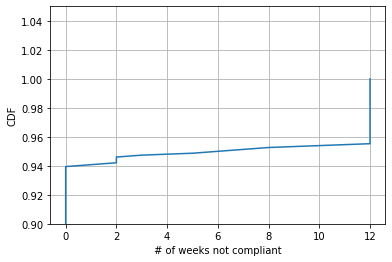

In [672]:
plt.plot(np.sort(ispincompliance['valid_percent']), np.linspace(0,1,len(ispincompliance)))
plt.xlabel('# of weeks not compliant')
plt.ylabel('CDF')
plt.ylim(bottom=0.9)
plt.grid()

## valid_percent timeseries for problematic ASes

In [673]:
def calc_valid_percent(f):
    date = datetime.strptime(f[-17:-7], '%Y-%m-%d')
    df = pd.read_csv(f, index_col=0)
    df = df[df.originasn_id.isin(suscdn+susisp)]
    df['either_status'] = df.apply(irr_or_rpki, axis=1)
    #df['either_status_strict'+date] = df.apply(irr_or_rpki_strict, axis=1)
    df_either = df.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()
    df_either['valid_percent'] = df_either[True]/(df_either[False] + df_either[True])*100
    df_either['date'] = date 

In [674]:
lc[lc.originasn_id.isin(susisp)]

either_status,originasn_id,valid_percent,totalPO,date
8,174,60.755287,3310,2022-02-06
23,1221,58.583106,367,2022-02-06
53,3356,43.814433,776,2022-02-06
55,3549,7.244502,773,2022-02-06
73,5511,88.000000,75,2022-02-06
...,...,...,...,...
9096,262983,63.793103,58,2022-05-01
9110,263565,100.000000,4,2022-05-01
9112,263653,100.000000,3,2022-05-01
9170,266525,75.000000,4,2022-05-01


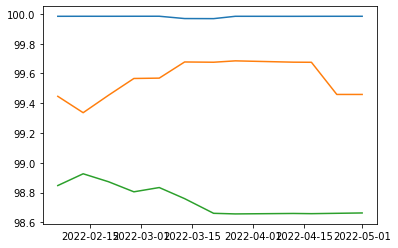

In [675]:
for i in suscdn:
    plt.plot(lc[lc.originasn_id == i]['date'], lc[lc.originasn_id == i]['valid_percent'])

In [680]:
lc[lc.originasn_id == 13335]

either_status,originasn_id,valid_percent,totalPO,date
158,13335,100.0,1267,2022-02-06
928,13335,100.0,1273,2022-02-13
1697,13335,100.0,1285,2022-02-20
2467,13335,100.0,1288,2022-02-27
3238,13335,100.0,1290,2022-03-06
4009,13335,100.0,1293,2022-03-13
4781,13335,100.0,1295,2022-03-21
5553,13335,100.0,1318,2022-03-27
6324,13335,100.0,1381,2022-04-12
7093,13335,100.0,1401,2022-04-17


In [875]:
suscdn

7    16509
8    20473
9    20940
Name: originasn_id, dtype: int64

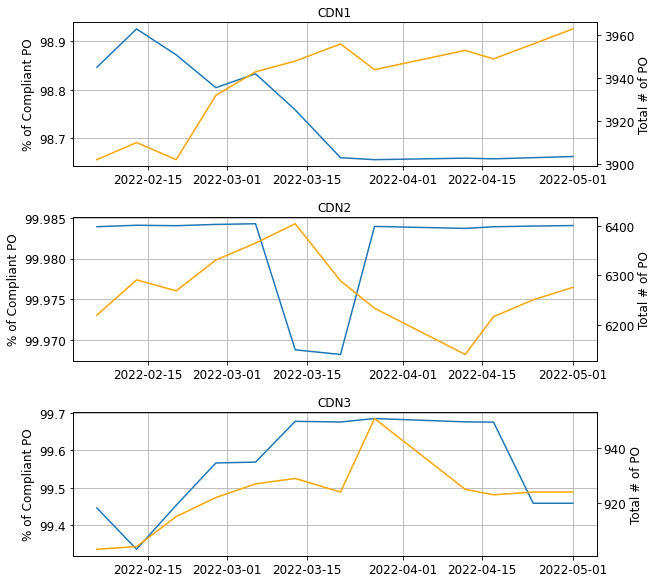

In [886]:
fig, axes = plt.subplots(len(suscdn), 1, figsize=(8,8))
fig.tight_layout(h_pad=3)
for i, v in enumerate([suscdn[9], suscdn[7], suscdn[8]]):
    axes[i].plot(lc[lc.originasn_id == v]['date'], lc[lc.originasn_id == v]['valid_percent'])
    ax2 = axes[i].twinx()
    ax2.plot(lc[lc.originasn_id == v]['date'], lc[lc.originasn_id == v]['totalPO'], color='orange')
    
#     axes[i].set_title('AS{}, {}'.format(v, manrs_org[v]))
    axes[i].set_title('CDN{}'.format(i+1), fontsize=12)
    axes[i].set_ylabel('% of Compliant PO', fontsize=12)
    axes[i].tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
    ax2.set_ylabel('Total # of PO', fontsize=12)
    axes[i].grid()
plt.savefig('cdnlong.eps', bbox_inches='tight')

## CDN analysis

In [823]:
longdataset

['/project/manic-geo/irr/ihr/origin_2022-02-06.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-13.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-20.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-02-27.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-06.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-13.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-21.csv.gz',
 '/project/manic-geo/irr/ihr/origin_2022-03-27.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-12.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-17.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-04-24.csv.gz',
 '/project/manic-geo/irr/ihr/origin_v4_2022-05-01.csv.gz']

In [827]:
s1 = pd.read_csv(longdataset[0])
s2 = pd.read_csv(longdataset[-1])
s1 = s1[(s1.af == 4) & s1.originasn_id.isin(suscdn)]
s2 = s2[(s2.af == 4) & s2.originasn_id.isin(suscdn)]

In [855]:
s1['either'] = s1.apply(irr_or_rpki, axis=1)
s2['either'] = s2.apply(irr_or_rpki, axis=1)

In [856]:
d2 = s1[['prefix', 'originasn_id', 'either']].merge(s2[['prefix', 'originasn_id', 'either']], on=['prefix', 'originasn_id'], how='outer')

In [865]:
def compare_status(x):
    if pd.isnull(x['either_x']):
        return 'new'
    if pd.isnull(x['either_y']):
        return 'lost'
    if x['either_x'] == x['either_y']:
        return 'same'
    if x['either_x'] != x['either_y']:
        return 'changed'
    return 'changed'

In [866]:
d2['status'] = d2.apply(compare_status, axis=1)

In [867]:
akamaid = d2[d2.originasn_id == 20940]

In [868]:
akamaid['status'].value_counts()

same    3822
new      141
lost      80
Name: status, dtype: int64

In [869]:
d2[d2.originasn_id == 16509]['status'].value_counts()

same    5687
new      589
lost     533
Name: status, dtype: int64

In [932]:
d2[d2.originasn_id == 20473]['status'].value_counts()

same       879
new         43
lost        22
changed      2
Name: status, dtype: int64

In [933]:
879+43-22

900

In [837]:
d1['drpki'] = d1.apply(lambda x: x['rpki_status_x'] == x['rpki_status_y'], axis=1)
d1['dirr'] = d1.apply(lambda x: x['irr_status_x'] == x['irr_status_y'], axis=1)

In [843]:
d1[d1.dirr == False]

,prefix,originasn_id,rpki_status_x,irr_status_x,rpki_status_y,irr_status_y,drpki,dirr
1156,23.72.37.0/24,20940,NotFound,"Invalid,more-specific",NotFound,Valid,True,False
2390,23.72.36.0/24,20940,NotFound,"Invalid,more-specific",NotFound,Valid,True,False


In [832]:
s2[~s2.prefix.isin(s1.prefix) & ~s]

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
5084,704060,1415684871,2022-05-01 00:00:00+00,23.212.167.0/24,0.258503,4,26.775956,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,FR,20940
6142,705744,1415683337,2022-05-01 00:00:00+00,200.60.136.0/23,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940
80246,1122282,1415266869,2022-05-01 00:00:00+00,23.192.145.0/24,1.000000,4,100.000000,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,US,20940
89815,1174468,1415215447,2022-05-01 00:00:00+00,23.34.80.0/24,1.000000,4,100.000000,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,US,20940
92667,1189631,1415199878,2022-05-01 00:00:00+00,13.225.119.0/24,1.000000,4,98.907104,Valid,Valid,assigned,assigned,Amazon - Cloudfront,f,16509,US,16509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923084,5287709,1411101366,2022-05-01 00:00:00+00,91.236.66.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Amazon EC2 Prefix,f,16509,GB,16509
923926,5290730,1411098327,2022-05-01 00:00:00+00,75.2.48.0/20,1.000000,4,98.907104,Valid,"Invalid,more-specific",assigned,assigned,Amazon Prod,f,16509,US,16509
924384,5292124,1411097385,2022-05-01 00:00:00+00,52.92.0.0/22,1.000000,4,100.000000,Valid,"Invalid,more-specific",assigned,assigned,Amazon ICN prefix,f,16509,IE,16509
925151,5294462,1411095047,2022-05-01 00:00:00+00,16.12.10.0/24,1.000000,4,100.000000,Valid,"Invalid,more-specific",assigned,assigned,Amazon AWS Services,f,16509,SE,16509


In [829]:
s2

,Unnamed: 0,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
1967,696416,1415692553,2022-05-01 00:00:00+00,23.196.229.0/24,0.258503,4,26.229508,NotFound,Valid,assigned,assigned,Akamai Technologies,t,20940,US,20940
5084,704060,1415684871,2022-05-01 00:00:00+00,23.212.167.0/24,0.258503,4,26.775956,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,FR,20940
5090,704074,1415684857,2022-05-01 00:00:00+00,23.46.147.0/24,0.258503,4,26.775956,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,FR,20940
5236,704404,1415685093,2022-05-01 00:00:00+00,23.35.65.0/24,0.244898,4,25.683060,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,FR,20940
5577,704774,1415684010,2022-05-01 00:00:00+00,23.205.215.0/24,0.013605,4,10.382514,NotFound,Valid,assigned,assigned,Akamai Technologies,f,20940,JP,20940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925153,5294465,1411095044,2022-05-01 00:00:00+00,15.197.13.0/24,1.000000,4,98.907104,Valid,Valid,assigned,assigned,Amazon EC2 Prefix,f,16509,US,16509
925154,5294469,1411095040,2022-05-01 00:00:00+00,15.193.0.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Amazon EC2 BOM prefix,f,16509,IN,16509
925155,5294472,1411095037,2022-05-01 00:00:00+00,15.177.89.0/24,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Amazon EC2 DUB prefix,f,16509,IE,16509
925156,5294474,1411095035,2022-05-01 00:00:00+00,15.161.0.0/16,1.000000,4,100.000000,Valid,Valid,assigned,assigned,Amazon EC2 MXP prefix,f,16509,IT,16509


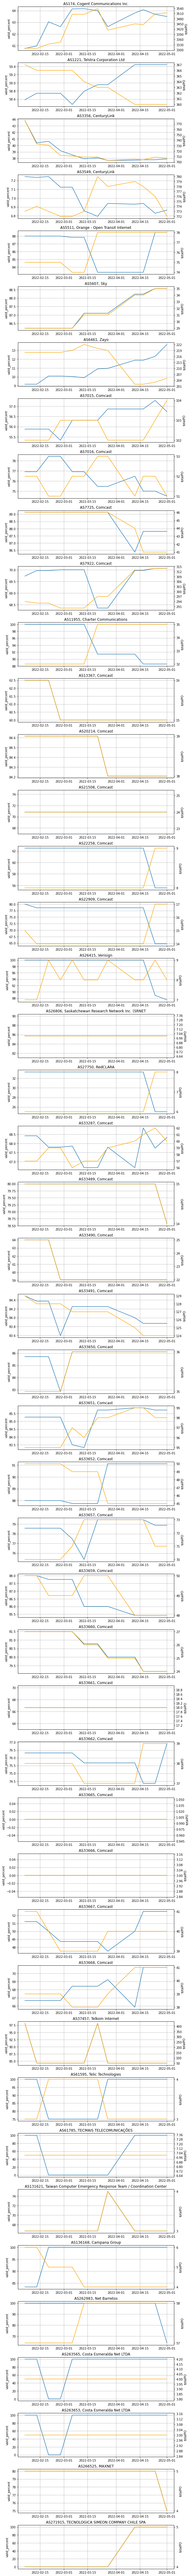

In [888]:
fig, axes = plt.subplots(len(ispincompliance[(ispincompliance.valid_percent > 0) ]), 1, figsize=(8,120))
fig.tight_layout(h_pad=2)
for i, v in enumerate(ispincompliance[(ispincompliance.valid_percent > 0) ]['originasn_id']):
    axes[i].plot(lc[lc.originasn_id == v]['date'], lc[lc.originasn_id == v]['valid_percent'])
    ax2 = axes[i].twinx()
    ax2.plot(lc[lc.originasn_id == v]['date'], lc[lc.originasn_id == v]['totalPO'], color='orange')
    
    axes[i].set_title('AS{}, {}'.format(v, manrs_org[v]))
    axes[i].set_ylabel('valid_percent')
    ax2.set_ylabel('totalPO')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[i].grid()
#     axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i,0].xaxis.get_major_locator()))
# fig.text(0.5, 0.1, 'date', ha='center', fontsize=15)
# fig.text(0.08, 0.5, '# of PO Pairs', va='center', rotation='vertical', fontsize=15)

In [600]:
isplc[isplc.originasn_id == 3549]['valid_percent'].values

array([list([10.558252427184465, 10.545454545454545, 10.558252427184465, 10.449574726609963, 10.449574726609963, 10.194174757281553, 10.108303249097473, 10.253317249698432, 6.93196405648267, 6.940874035989718, 6.829896907216495, 6.865284974093264])],
      dtype=object)

In [590]:
cdnlc = lc[lc.originasn_id.isin(suscdn)].groupby('originasn_id').agg({'valid_percent':list, 'totalPO': list})

In [591]:
cdnlc

either_status,valid_percent,totalPO
originasn_id,,
13335,"[99.91007194244604, 99.90946129470348, 99.9101...","[2224, 2209, 2227, 2233, 2237, 2240, 2255, 228..."
16509,"[99.68191827746513, 99.6858006042296, 99.68423...","[8174, 8275, 8234, 8325, 8378, 8448, 8333, 827..."
20473,"[99.56217162872154, 99.34883720930232, 99.4439...","[1142, 1075, 1079, 1087, 1141, 1209, 1124, 113..."
20940,"[98.90604890604891, 98.97260273972603, 98.9293...","[4662, 4672, 4670, 4701, 4711, 4689, 4726, 470..."


In [181]:
manrs_origin[manrs_origin.originasn_id == 399214]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype,either_status
1907535,1414481441,2022-05-01 00:00:00+00,142.202.154.0/24,1.0,4,100.0,Valid,Valid,assigned,assigned,Joust Security Inc.\n925 boul. de Maisonneuve ...,f,399214,CA,399214,ISP,True
2268820,1414120147,2022-05-01 00:00:00+00,45.42.168.0/23,1.0,4,100.0,Valid,Valid,assigned,assigned,The Ministry of Compute Inc.\n925 boul. de Mai...,f,399214,US,399214,ISP,True
2976898,1413412213,2022-05-01 00:00:00+00,158.51.10.0/24,1.0,4,100.0,Valid,Valid,assigned,assigned,Eau Noire Inc.\n925 boul. de Maisonneuve Ouest...,f,399214,CA,399214,ISP,True


earier version: diff 2107 and 2204 snapshots

In [145]:
ihr2107 = pd.read_csv(ihr[0])
ihr2204 = pd.read_csv(ihr[-1])

In [146]:
ihr2107_manrs = ihr2107[ihr2107['originasn_id'].isin(manrsas)]
ihr2204_manrs = ihr2204[ihr2204['originasn_id'].isin(manrsas)]

In [147]:
ihr2107_manrs['either_status'] = ihr2107_manrs.apply(irr_or_rpki, axis=1)
ihr2204_manrs['either_status'] = ihr2204_manrs.apply(irr_or_rpki, axis=1)

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [148]:
ihr2107_either = ihr2107_manrs.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()
ihr2204_either = ihr2204_manrs.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

In [149]:
ihr2107_either['valid_percent'] = ihr2107_either[True]/(ihr2107_either[False] + ihr2107_either[True])*100
ihr2204_either['valid_percent'] = ihr2204_either[True]/(ihr2204_either[False] + ihr2204_either[True])*100

In [150]:
ihr2107_either

either_status,originasn_id,False,True,valid_percent
0,87,0,19,100.00
1,88,0,12,100.00
2,92,0,5,100.00
3,101,0,8,100.00
4,103,0,23,100.00
...,...,...,...,...
779,395262,0,2,100.00
780,396955,1,15,93.75
781,396961,0,10,100.00
782,398866,0,1,100.00


In [151]:
ihr2204_either

either_status,originasn_id,False,True,valid_percent
0,87,0,19,100.000000
1,88,0,12,100.000000
2,92,0,5,100.000000
3,101,0,8,100.000000
4,103,0,23,100.000000
...,...,...,...,...
777,395262,0,2,100.000000
778,396955,1,16,94.117647
779,396961,0,10,100.000000
780,398866,0,2,100.000000


In [152]:
manrs_range = ihr2107_either.merge(ihr2204_either, on=['originasn_id'], how='outer', suffixes=('_2107', '_2204'))

In [153]:
def delta_valid_percent(x,y):
    if pd.isnull(x)

SyntaxError: invalid syntax (461708672.py, line 2)

In [ ]:
manrs_range['delta_valid'] = manrs_range['valid_percent_2204'] - manrs_range['valid_percent_2107']

In [ ]:
manrs_range

In [ ]:
plt.plot(np.sort(manrs_range.delta_valid), np.linspace(0,1,len(manrs_range.delta_valid)))

In [695]:
origindf[(origindf.rpki_status == 'Invalid') | (origindf.rpki_status == 'Invalid,more-specific')].drop_duplicates(subset=['prefix', 'originasn_id'])

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
691998,1415697039,2022-05-01 00:00:00+00,178.22.137.0/24,0.006803,4,9.289617,"Invalid,more-specific",Valid,assigned,assigned,Simwood eSMS Limited (London) - Customers,f,42353,GB,42353
692238,1415696900,2022-05-01 00:00:00+00,191.97.106.0/24,0.020408,4,10.382514,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
692240,1415696898,2022-05-01 00:00:00+00,179.51.75.0/24,0.034014,4,11.475410,"Invalid,more-specific",Valid,assigned,assigned,COLUMBUS NETWORKS TRANSIT CUSTOMERS,f,52471,DO,52471
692247,1415696891,2022-05-01 00:00:00+00,191.97.105.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
692258,1415696880,2022-05-01 00:00:00+00,186.148.93.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291436,1411097719,2022-05-01 00:00:00+00,61.246.214.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291501,1411097602,2022-05-01 00:00:00+00,59.145.202.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291504,1411097599,2022-05-01 00:00:00+00,59.145.238.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291528,1411097575,2022-05-01 00:00:00+00,59.144.120.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498


In [693]:
origindf[origindf.rpki_status == 'Invalid,more-specific']

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
691998,1415697039,2022-05-01 00:00:00+00,178.22.137.0/24,0.006803,4,9.289617,"Invalid,more-specific",Valid,assigned,assigned,Simwood eSMS Limited (London) - Customers,f,42353,GB,42353
692238,1415696900,2022-05-01 00:00:00+00,191.97.106.0/24,0.020408,4,10.382514,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
692240,1415696898,2022-05-01 00:00:00+00,179.51.75.0/24,0.034014,4,11.475410,"Invalid,more-specific",Valid,assigned,assigned,COLUMBUS NETWORKS TRANSIT CUSTOMERS,f,52471,DO,52471
692247,1415696891,2022-05-01 00:00:00+00,191.97.105.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
692258,1415696880,2022-05-01 00:00:00+00,186.148.93.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,LACNIC generated route for Columbus Networks D...,f,52471,DO,52471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291436,1411097719,2022-05-01 00:00:00+00,61.246.214.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291501,1411097602,2022-05-01 00:00:00+00,59.145.202.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291504,1411097599,2022-05-01 00:00:00+00,59.145.238.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
5291528,1411097575,2022-05-01 00:00:00+00,59.144.120.0/24,0.680272,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,9498,IN,9498
